# Provision Audio

In [1]:
import parselmouth
from parselmouth import praat
from parselmouth.praat import call
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import librosa
import librosa.display
import sounddevice as sd
from datetime import datetime
from tqdm import tqdm
import seaborn as sns
import matplotlib.patches as patches

### Hyperparameter

In [2]:
F1_MIN, F1_MAX = 200, 1200    # F1 범위 (Hz)
F2_MIN, F2_MAX = 500, 3000   # F2 범위 (Hz)

## Word Level Analysis

In [3]:
filePath = "../audio-sample/short-version-phonetic"
audio_list = os.listdir(filePath)
audio_list = [file for file in audio_list if file.endswith(".wav")]
audio_list.sort()
audio_list

['난색.wav',
 '난파.wav',
 '내빈.wav',
 '내사.wav',
 '녹각.wav',
 '논개.wav',
 '누룩.wav',
 '누진.wav',
 '닌자.wav',
 '닝닝.wav',
 '말미.wav',
 '망루.wav',
 '매복.wav',
 '맹호.wav',
 '몰딩.wav',
 '몽매.wav',
 '무골.wav',
 '무운.wav',
 '미비.wav',
 '밀사.wav',
 '박애.wav',
 '발탁.wav',
 '백태.wav',
 '뱃심.wav',
 '복시.wav',
 '봉독.wav',
 '분개.wav',
 '불모.wav',
 '비재.wav',
 '빈축.wav',
 '상기.wav',
 '상록.wav',
 '새참.wav',
 '샐쭉.wav',
 '소조.wav',
 '송부.wav',
 '수하.wav',
 '술책.wav',
 '시문.wav',
 '실족.wav',
 '파군.wav',
 '판본.wav',
 '패물.wav',
 '팽배.wav',
 '포문.wav',
 '폭압.wav',
 '품띠.wav',
 '풍산.wav',
 '피폭.wav',
 '필생.wav']

In [4]:
def formant_analysis(file_Path, audio_name, start_time=0, end_time=0, time_step=0.01):
    # WAV 파일 불러오기
    print("filePath", file_Path)
    print("audio_name", audio_name)
    sound = parselmouth.Sound(os.path.join(file_Path, audio_name))
    if end_time == 0:
        end_time = sound.duration
    
    if time_step == -1:
        if start_time !=0 and end_time !=0:
            time_step = end_time - start_time
        else:
            time_step = sound.duration
    #print(sound.duration)
    # 평균 음원 길이 약 .7s 정도
    #time_step = 0.01
    time_points = np.arange(start_time, end_time, time_step)
    f1_list = []
    f2_list = []
    
    # 포먼트 추출 (Burg 방식 사용)
    formants = sound.to_formant_burg(time_step=time_step, 
                                    max_number_of_formants=5.0,
                                    maximum_formant=5000.0, 
                                    window_length=0.025, 
                                    pre_emphasis_from=50.0)

    for time_point in time_points:
        # 특정 시간에서의 F1, F2 값 추출
        f1 = formants.get_value_at_time(1, time_point)
        f2 = formants.get_value_at_time(2, time_point)
        f1_list.append(f1)
        f2_list.append(f2)

        """
        if (f1 and f2 and 
            np.isfinite(f1) and np.isfinite(f2) and
            F1_MIN <= f1 <= F1_MAX and 
            F2_MIN <= f2 <= F2_MAX and 
            (f2 - f1) >= 200):  # F2-F1 최소 차이
            f1_list.append(f1)
            f2_list.append(f2)
        """


    formant_df = pd.DataFrame({"f1": f1_list, "f2": f2_list, "time": time_points})
    return formant_df


def plot_formant_distribution(audio_name, file_Path, ax=None, start_time=0, end_time=0):    
    # 고정된 축 범위 설정
    F1_MIN, F1_MAX = 200, 1200    # F1 범위 (Hz)
    F2_MIN, F2_MAX = 500, 3000   # F2 범위 (Hz)
    
    # take formant list
    formant_df = formant_analysis(file_Path, audio_name, start_time, end_time)

    # 산점도 그리기
    scatter = sns.scatterplot(data=formant_df, 
                         x="f1", 
                         y="f2", 
                         hue="time", 
                         palette="viridis", 
                         alpha=0.5, 
                         s=50,
                         ax=ax)

    # 축 반전 (언어학 관례)
    #ax.invert_xaxis()
    #ax.invert_yaxis()

    # 축 범위 설정
    ax.set_xlim(F1_MAX, F1_MIN)  # F2 축 반전
    ax.set_ylim(F2_MAX, F2_MIN)  # F1 축 반전
    
    # 제목과 레이블 설정
    ax.set_title(f'포먼트 분포도: {audio_name}', fontsize=12, pad=10)
    ax.set_xlabel('F1 (Hz)', fontsize=10)
    ax.set_ylabel('F2 (Hz)', fontsize=10)

    # 컬러바 설정
    norm = plt.Normalize(formant_df['time'].min(), formant_df['time'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax).set_label('시간 (초)', fontsize=8)

    # 그리드 설정
    ax.grid(True, linestyle='--', alpha=0.7)
    
    return formant_df

filePath ../audio-sample/short-version-phonetic
audio_name 난색.wav
filePath ../audio-sample/short-version-phonetic
audio_name 난파.wav
filePath ../audio-sample/short-version-phonetic
audio_name 내빈.wav
filePath ../audio-sample/short-version-phonetic
audio_name 내사.wav
filePath ../audio-sample/short-version-phonetic
audio_name 녹각.wav
filePath ../audio-sample/short-version-phonetic
audio_name 논개.wav
filePath ../audio-sample/short-version-phonetic
audio_name 누룩.wav
filePath ../audio-sample/short-version-phonetic
audio_name 누진.wav
filePath ../audio-sample/short-version-phonetic
audio_name 닌자.wav
filePath ../audio-sample/short-version-phonetic
audio_name 닝닝.wav
filePath ../audio-sample/short-version-phonetic
audio_name 말미.wav
filePath ../audio-sample/short-version-phonetic
audio_name 망루.wav
filePath ../audio-sample/short-version-phonetic
audio_name 매복.wav
filePath ../audio-sample/short-version-phonetic
audio_name 맹호.wav
filePath ../audio-sample/short-v

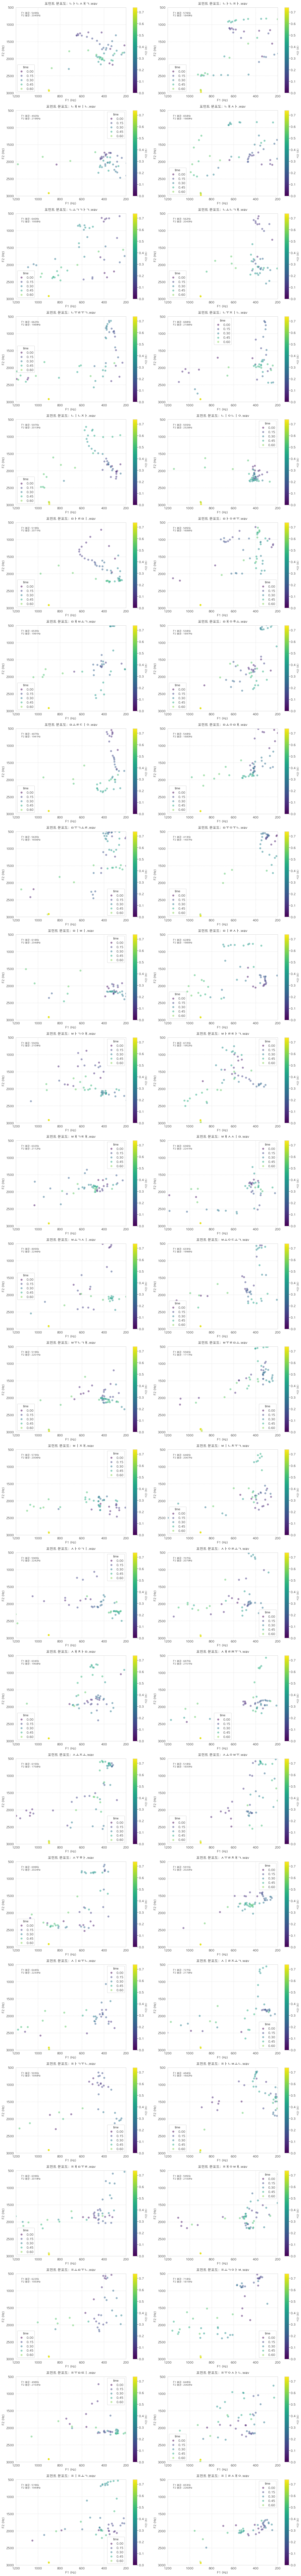

In [5]:
# 메인 코드
# 기본 스타일 설정
sns.set_style("whitegrid")
# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['AppleGothic']  # macOS의 경우
#plt.rcParams['font.family'] = 'sans-serif'


# 서브플롯 개수 계산
n_plots = len(audio_list)
n_cols = 2  # 열 개수 지정
n_rows = (n_plots + 1) // 2  # 행 개수 계산 (올림)

# Figure 생성
fig = plt.figure(figsize=(15, 5*n_rows))

# 각 오디오 파일에 대해 서브플롯 생성
for idx, audio_name in enumerate(audio_list, 1):
    ax = fig.add_subplot(n_rows, n_cols, idx)
    formant_df = plot_formant_distribution(audio_name, filePath, ax)
    
    # 통계 정보를 타이틀 아래에 추가 (선택사항)
    stats = formant_df.describe().round(2)
    ax.text(0.05, 0.95, 
            f'F1 평균: {stats["f1"]["mean"]:.0f}Hz\nF2 평균: {stats["f2"]["mean"]:.0f}Hz',
            transform=ax.transAxes,
            fontsize=8,
            verticalalignment='top')

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

In [6]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def visualize_phoneme_segmentation(audio_path, method='librosa', start_time=None, end_time=None):
    # 오디오 로드
    if start_time is not None and end_time is not None:
        # 방법 2: offset과 duration 파라미터 사용
        duration = end_time - start_time
        y, sr = librosa.load(audio_path, sr=None, offset=start_time, duration=duration)
    elif start_time is not None:
        # start_time만 있는 경우
        y, sr = librosa.load(audio_path, sr=None, offset=start_time)
    else:
        # 전체 오디오 로드
        y, sr = librosa.load(audio_path, sr=None)
    
    # 시간 축 범위 설정 (모든 서브플롯에 공통으로 적용)
    time_max = len(y) / sr
    time_axis = np.linspace(0, time_max, len(y))
    
    if method == 'librosa':
        # MFCC 특성 추출 - hop_length 통일
        hop_length = 256
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=hop_length)
        print(mfcc.shape)
        
        # 델타 특성 (변화량)
        mfcc_delta = librosa.feature.delta(mfcc)
        
        # 변화량이 큰 지점을 음소 경계로 추정
        changes = np.sum(np.abs(mfcc_delta), axis=0)
        distance = 10
        peaks, _ = find_peaks(changes, height=np.std(changes)*1.0, distance=distance)
        
        # 시간 단위로 변환 - 동일한 hop_length 사용
        boundaries = librosa.frames_to_time(peaks, sr=sr, hop_length=hop_length)
    
    # 결과 시각화
    fig = plt.figure(figsize=(15, 10))
    
    # 파형 플롯
    ax1 = plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr, ax=ax1)
    ax1.set_title('파형 (Waveform)', fontsize=12)
    ax1.set_xlabel('시간 (초)', fontsize=10)
    ax1.set_ylabel('진폭', fontsize=10)
    ax1.set_xlim(0, time_max)
    
    # 경계 표시
    for boundary in boundaries:
        ax1.axvline(x=boundary, color='r', linestyle='--', alpha=0.7)
    
    # 스펙트로그램 플롯
    ax2 = plt.subplot(3, 1, 2, sharex=ax1)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=ax2)
    fig.colorbar(img, ax=ax2, format='%+2.0f dB')
    ax2.set_title('스펙트로그램 (Spectrogram)', fontsize=12)
    ax2.set_xlabel('시간 (초)', fontsize=10)
    ax2.set_ylabel('주파수 (Hz)', fontsize=10)
    ax2.set_xlim(0, time_max)
    
    # 경계 표시
    for boundary in boundaries:
        ax2.axvline(x=boundary, color='r', linestyle='--', alpha=0.7)
    
    # MFCC 변화량
    ax3 = plt.subplot(3, 1, 3, sharex=ax1)
    # 동일한 hop_length 사용하여 시간 계산
    times = librosa.times_like(changes, sr=sr, hop_length=hop_length)
    ax3.plot(times, changes)
    ax3.set_title('MFCC 변화량 (MFCC Delta Sum)', fontsize=12)
    ax3.set_xlabel('시간 (초)', fontsize=10)
    ax3.set_ylabel('변화량 크기 (Delta Magnitude)', fontsize=10)
    ax3.set_xlim(0, time_max)
    
    # 피크(경계) 표시
    for boundary in boundaries:
        ax3.axvline(x=boundary, color='r', linestyle='--', alpha=0.7)
    
    # x축 통일을 위한 추가 설정 - 명시적으로 모든 서브플롯에 동일한 범위 적용
    plt.setp([ax1, ax2, ax3], xlim=(0, time_max))
    
    # 레이아웃 조정 및 서브플롯 간 간격 설정
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    
    # 음소 경계에 레이블 추가
    for i, boundary in enumerate(boundaries):
        if boundary <= time_max:  # 범위 내에 있는 경계만 레이블 추가
            ax3.annotate(f"{i+1}", 
                         xy=(boundary, max(changes) * 0.9),
                         xytext=(0, 5), 
                         textcoords='offset points',
                         ha='center',
                         fontsize=8)
    
    # 경계선 범례 추가
    ax1.plot([], [], 'r--', alpha=0.7, label='음소 경계')
    ax1.legend(loc='upper right')
    
    plt.show()
    
    # 경계 시간 출력
    print(f"총 {len(boundaries)}개의 음소 경계 탐지")
    for i, boundary in enumerate(boundaries):
        print(f"음소 경계 {i+1}: {boundary:.3f}초")
    
    return boundaries

word: 난색.wav
(13, 129)


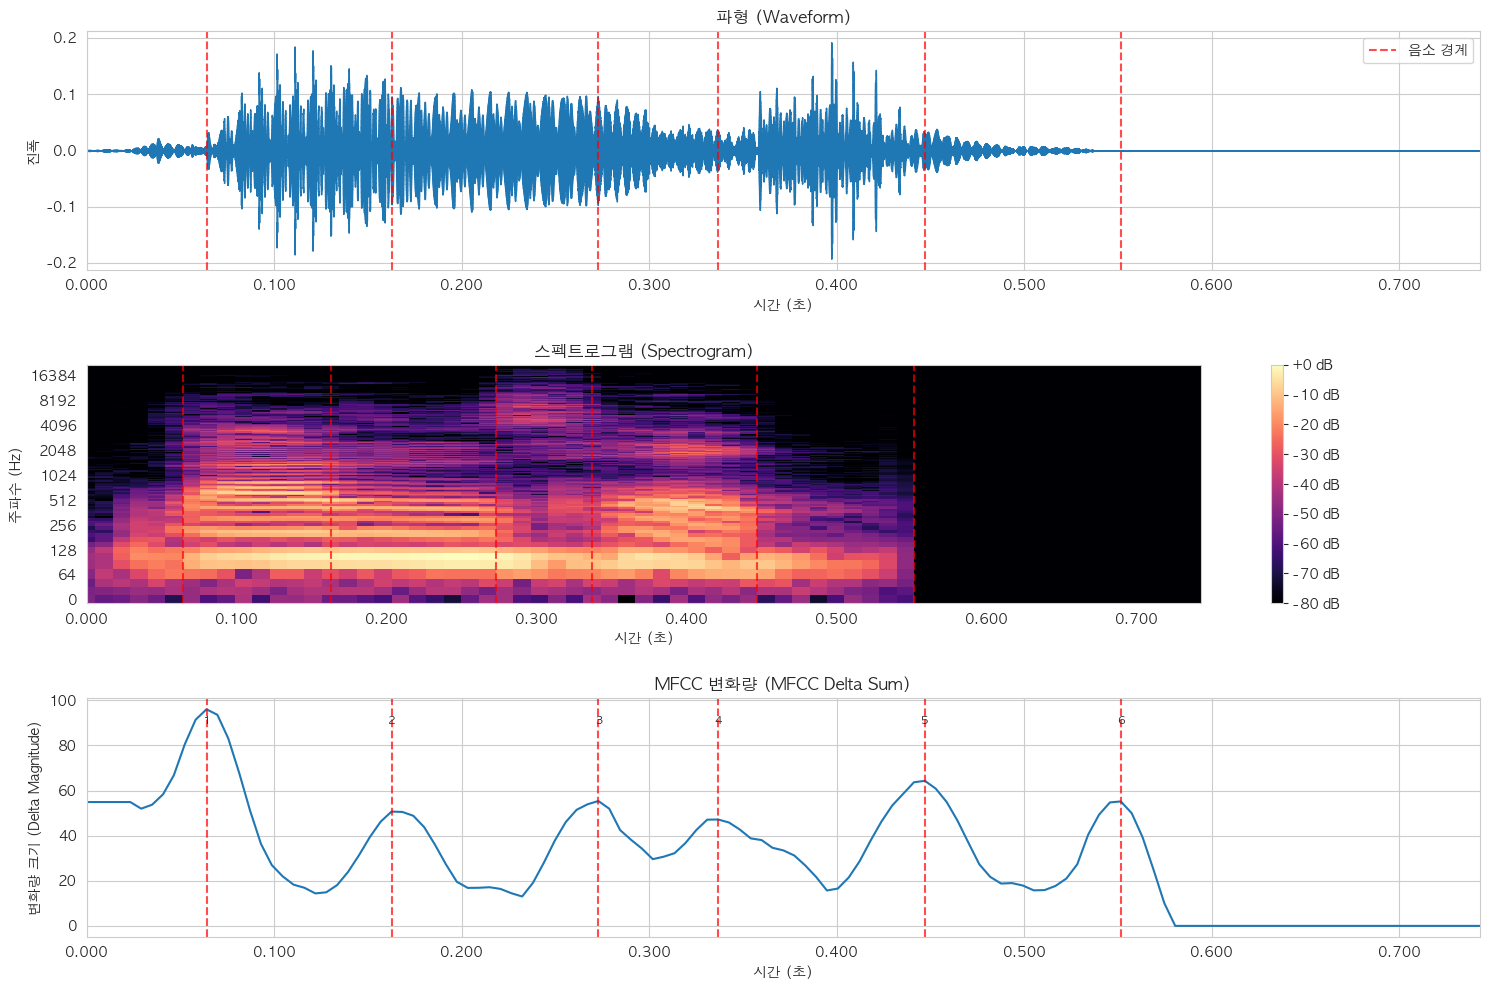

총 6개의 음소 경계 탐지
음소 경계 1: 0.064초
음소 경계 2: 0.163초
음소 경계 3: 0.273초
음소 경계 4: 0.337초
음소 경계 5: 0.447초
음소 경계 6: 0.551초


array([0.06385488, 0.16253968, 0.27283447, 0.33668934, 0.44698413,
       0.55147392])

In [7]:
idx=0
audio_path = os.path.join(filePath, audio_list[idx])
print(f"word: {audio_list[idx]}")
segments = visualize_phoneme_segmentation(audio_path)
segments

In [8]:
audio_path

'../audio-sample/short-version-phonetic/난색.wav'

In [9]:
segment_idx = 0
sample_y, sample_sr = librosa.load(audio_path)
#play_audio_segment(y=sample_y, sr=sample_sr, start_time=segments[segment_idx], end_time=segments[segment_idx+1])
play_audio_segment(y=sample_y, sr=sample_sr, start_time=segments[0], end_time=segments[1])

NameError: name 'play_audio_segment' is not defined

filePath ../audio-sample/short-version-phonetic
audio_name 난색.wav
filePath ../audio-sample/short-version-phonetic
audio_name 난색.wav
filePath ../audio-sample/short-version-phonetic
audio_name 난색.wav
filePath ../audio-sample/short-version-phonetic
audio_name 난색.wav
filePath ../audio-sample/short-version-phonetic
audio_name 난색.wav


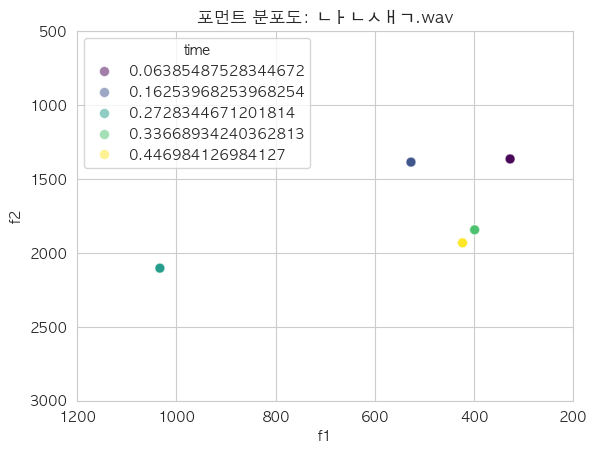

In [2425]:
for idx in range(len(segments)):
    if idx == len(segments)-1:
        continue
    if data is None:
        data = formant_analysis(filePath, audio_list[0], start_time=segments[idx], end_time=segments[idx+1], time_step=-1)
    else:
        data = pd.concat([data, formant_analysis(filePath, audio_list[0], start_time=segments[idx], end_time=segments[idx+1], time_step=-1)])
    

sns.scatterplot(data=data, x="f1", y="f2", hue="time", palette="viridis", alpha=0.5, s=50)
ax = plt.gca()
ax.set_xlim(F1_MAX, F1_MIN)
ax.set_ylim(F2_MAX, F2_MIN)
plt.title(f"포먼트 분포도: {audio_list[0]}")
plt.show()

In [80]:
data

,f1,f2,time
0,459.772505,1993.640636,0.446984
0,459.772505,1993.640636,0.063855
0,459.772505,1993.640636,0.162540
0,459.772505,1993.640636,0.272834
0,459.772505,1993.640636,0.336689
0,459.772505,1993.640636,0.446984


In [1113]:
segments

array([0.06385488, 0.16253968, 0.27283447, 0.33668934, 0.44698413,
       0.55147392])

In [38]:
sample_y, sample_sr = librosa.load(audio_path)
sample_y.shape

(16384,)

In [2465]:
def detect_syllable_boundaries(sound, threshold_db=-50, min_silence_duration=0.05):
    """
    음성(sound)에서 intensity(< threshold_db dB) 구간이 min_silence_duration 이상 연속되는
    지점을 무음(silence) 경계로 검출하여, 경계 리스트를 반환.
    """
    intensity = sound.to_intensity()  # dB 단위 intensity 객체 생성  [oai_citation:0‡parselmouth.readthedocs.io](https://parselmouth.readthedocs.io/en/latest/api/parselmouth.Formant.html?utm_source=chatgpt.com)
    times = intensity.xs()
    values = intensity.values[0]       # intensity.values: shape=(1, N)
    
    # threshold 이하인 프레임 마스크
    low_mask = values < threshold_db
    # 연속 구간 탐색
    boundaries = []
    start_idx = None
    for i, is_low in enumerate(low_mask):
        if is_low and start_idx is None:
            start_idx = i
        elif not is_low and start_idx is not None:
            dur = times[i-1] - times[start_idx]
            if dur >= min_silence_duration:
                midpoint = (times[start_idx] + times[i-1]) / 2
                boundaries.append(midpoint)
            start_idx = None
    # 파일 끝에서 종료된 경우 처리
    if start_idx is not None:
        dur = times[-1] - times[start_idx]
        if dur >= min_silence_duration:
            midpoint = (times[start_idx] + times[-1]) / 2
            boundaries.append(midpoint)
    return boundaries

# 사용 예시
snd = parselmouth.Sound(audio_path)
silence_points = detect_syllable_boundaries(snd)

In [2466]:
silence_points

[np.float64(0.6395192743764173)]

# Exp Audio

## word-level

In [3]:
def tokenization_audio2word(filePath):
    # 실험 결과 폴더 접근.
    for filename in os.listdir(filePath):
        # 특정 참가자 폴더 접근.
        if filename.startswith("participant_"):
            participant_folder = os.path.join(filePath, filename)
        else:
            pass

        # 참가자 폴더 내의 모든 wav 파일 접근.
        if len(os.listdir(participant_folder)) != 6:
            print(f"{filename} 폴더 내의 모든 wav 파일 개수가 6개가 아닙니다.")
            raise ValueError("참가자 폴더 내의 모든 wav 파일 개수가 6개가 아닙니다.")

        # 참가자 폴더 내의 모든 wav 파일 접근.  
        for file in os.listdir(participant_folder):
            # 
            if file.endswith(".wav"):
                print(file)

expFilePath = "../../../../Desktop/results"
participants_list = os.listdir(expFilePath)
print(participants_list)

"""
for participant in participants_list:
    filePath = os.path.join(expFilePath, participant)
    tokenization_audio2word(filePath)
"""

['participant_test0001', '.DS_Store', 'participant_LY017', 'participant_LY028', 'participant_LY010', 'participant_LY026', 'participant_LY019', 'participant_LY021', 'participant_LY027', 'participant_LY018', 'participant_LY016', 'participant_LY029', 'participant_LY034', 'survey.xlsx', 'participant_LY033', 'pilot-02', 'participant_LY005', 'participant_LY002', 'participant_LY003', 'participant_LY004', 'participant_LY032', 'participant_LY035', '~$survey.xlsx', 'participant_LY011(v)', 'participant_LY001(v)', 'participant_LY022(v)', 'participant_LY013', 'participant_LY014', 'participant_LY025', 'participant_LY040', 'participant_LY024', 'participant_LY023', 'participant_LY015', 'participant_LY012', 'participant_test001', 'participant_LY037', 'participant_LY039', 'pilot-01', 'participant_LY006', 'participant_LY038', 'participant_LY007', 'participant_LY009', 'participant_LY036', 'participant_LY031']


'\nfor participant in participants_list:\n    filePath = os.path.join(expFilePath, participant)\n    tokenization_audio2word(filePath)\n'

In [4]:
def load_audio(file_path: str):
    """
    오디오 파일을 로드합니다.
    
    Args:
        file_path (str): 오디오 파일 경로
    
    Returns:
        tuple: (y, sr) 오디오 데이터와 샘플링 레이트
    """
    try:
        # librosa를 사용하여 오디오 로드
        y, sr = librosa.load(file_path, sr=44100)
        return y, sr
    except Exception as e:
        print(f"오디오 로드 중 오류 발생: {str(e)}")
        # parselmouth를 사용하여 대체 로드 시도
        try:
            sound = parselmouth.Sound(file_path)
            y = sound.values
            sr = sound.sampling_frequency
            return y, sr
        except Exception as e2:
            print(f"대체 로드 중 오류 발생: {str(e2)}")
            raise

In [5]:
def play_audio_segment(y, sr:int, start_time:float, end_time:float):
    """
    오디오의 특정 구간을 재생합니다.
    
    Args:
        y (np.ndarray): 오디오 데이터
        sr (int): 샘플링 레이트
        start_time (float): 시작 시간 (초)
        end_time (float): 종료 시간 (초)
    """
    sd._terminate()
    sd._initialize()
    sd.query_devices()
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    segment = y[start_sample:end_sample]
    
    print("재생 중...", end='', flush=True)
    sd.play(segment, sr)
    sd.wait()
    print(" 완료")

In [6]:
def check_excel_info(file_path):
    """
    엑셀 파일의 시트 정보를 확인합니다.
    
    Args:
        file_path (str): 엑셀 파일 경로
    """
    try:
        # 엑셀 파일의 모든 시트 정보 가져오기
        excel_file = pd.ExcelFile(file_path)
        sheet_names = excel_file.sheet_names
        
        print(f"\n파일명: {os.path.basename(file_path)}")
        print(f"총 시트 수: {len(sheet_names)}")
        print("\n시트 목록:")
        for i, sheet_name in enumerate(sheet_names, 1):
            # 각 시트의 기본 정보 가져오기
            df = pd.read_excel(file_path, sheet_name=sheet_name)
            print(f"\n{i}. 시트명: {sheet_name}")
            print(f"   - 행 수: {len(df)}")
            print(f"   - 열 수: {len(df.columns)}")
            print(f"   - 열 이름: {list(df.columns)}")
            
    except Exception as e:
        print(f"오류 발생: {str(e)}")

In [7]:
from pydub import AudioSegment, silence
import os

def word_segmentation(audio_path: str, excel_path: str):

    #result
    start_time_list = []
    end_time_list = []

    # load audio(Sequential file format)
    y, sr = load_audio(audio_path)
    # load audio(AudioSegment)
    audio = AudioSegment.from_file(audio_path)

    # detect nonsilent ranges
    nonsilent_ranges = silence.detect_nonsilent(audio, min_silence_len=380, silence_thresh=-49, seek_step=1)
    """
    audio: 오디오 파일, 위에서 load한 결과물
    min_silence_len: 최소 묵음 길이 (ms), 이 길이보다 짧은 묵음은 무시
    silence_thresh: 묵음 임계치 (dB), 이 값보다 작은 값은 묵음으로 판단
    seek_step: 탐색 단계 (ms), 탐색 단계만큼 건너뛰어 탐색
    """

    print(f"detected segments: {len(nonsilent_ranges)}")

    # play audio segment
    for start_ms, end_ms in nonsilent_ranges:
        # padding for ending time
        padding = 0.2
        start_sec = start_ms / 1000
        start_sec = start_sec - padding if start_sec - padding > 0 else 0
        end_sec = end_ms / 1000 
        end_sec = end_sec + padding if end_sec + padding < audio.duration_seconds else audio.duration_seconds

        # append result
        start_time_list.append(start_sec)
        end_time_list.append(end_sec)

        # play audio segment
        #play_audio_segment(y=y, sr=sr, start_time=start_sec, end_time=end_sec)
        print(f"시작: {start_sec:.2f}초, 끝: {end_sec:.2f}초")
    return start_time_list, end_time_list

In [8]:
def save_excel(excel_path, sheet_name, start_time_list, end_time_list):
    sheet = pd.read_excel(excel_path, sheet_name=sheet_name)
    sheet['start_time'] = start_time_list
    sheet['end_time'] = end_time_list

    with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        sheet.to_excel(writer, sheet_name=sheet_name, index=False)

In [9]:
"""
expPath = "../../../../Desktop/results"
participants_list = os.listdir(expPath)
participants_list = [participant for participant in participants_list if participant.startswith("participant_")]
participants_list.sort()

for participant in participants_list:
    # access to the participant folder
    participant_path = os.path.join(expPath, participant)

    # check the folder is ready to analyze
    wav_file_list = os.listdir(participant_path)
    wav_file_list = [file for file in wav_file_list if file.endswith(".wav")]
    if len(wav_file_list) != 6:
        print(f"{participant} 폴더 내의 모든 wav 파일 개수가 6개가 아닙니다.")
        continue

    # access to the audio file
    audio_list = [f for f in os.listdir(participant_path) if f.endswith(".wav")]
    audio_list.sort()
    

    # access to the excel file
    excel_file_path = list(os.listdir(participant_path))
    excel_file_path = [file for file in excel_file_path if file.endswith(".xlsx")][0]
    excel_file_path = os.path.join(participant_path, excel_file_path)
    excel_file = pd.ExcelFile(excel_file_path)
    
    # access to the sheet
    for stage_idx, sheet_name in enumerate(excel_file.sheet_names):
        if not 'Stage' in sheet_name:
            continue
        
        audio_path = os.path.join(participant_path, audio_list[stage_idx-1])
        sheet = pd.read_excel(excel_file_path, sheet_name=sheet_name)

        start_time_list, end_time_list = word_segmentation(audio_path, excel_file_path)
        save_excel(excel_file_path, sheet_name, start_time_list, end_time_list)
"""
        

'\nexpPath = "../../../../Desktop/results"\nparticipants_list = os.listdir(expPath)\nparticipants_list = [participant for participant in participants_list if participant.startswith("participant_")]\nparticipants_list.sort()\n\nfor participant in participants_list:\n    # access to the participant folder\n    participant_path = os.path.join(expPath, participant)\n\n    # check the folder is ready to analyze\n    wav_file_list = os.listdir(participant_path)\n    wav_file_list = [file for file in wav_file_list if file.endswith(".wav")]\n    if len(wav_file_list) != 6:\n        print(f"{participant} 폴더 내의 모든 wav 파일 개수가 6개가 아닙니다.")\n        continue\n\n    # access to the audio file\n    audio_list = [f for f in os.listdir(participant_path) if f.endswith(".wav")]\n    audio_list.sort()\n    \n\n    # access to the excel file\n    excel_file_path = list(os.listdir(participant_path))\n    excel_file_path = [file for file in excel_file_path if file.endswith(".xlsx")][0]\n    excel_file_path = 

In [10]:
expPath = "../../../../Desktop/results"
participants_list = os.listdir(expPath)
participants_list = [participant for participant in participants_list if participant.startswith("participant_")]
participants_list.sort()     
participants_list   

['participant_LY001(v)',
 'participant_LY002',
 'participant_LY003',
 'participant_LY004',
 'participant_LY005',
 'participant_LY006',
 'participant_LY007',
 'participant_LY009',
 'participant_LY010',
 'participant_LY011(v)',
 'participant_LY012',
 'participant_LY013',
 'participant_LY014',
 'participant_LY015',
 'participant_LY016',
 'participant_LY017',
 'participant_LY018',
 'participant_LY019',
 'participant_LY021',
 'participant_LY022(v)',
 'participant_LY023',
 'participant_LY024',
 'participant_LY025',
 'participant_LY026',
 'participant_LY027',
 'participant_LY028',
 'participant_LY029',
 'participant_LY031',
 'participant_LY032',
 'participant_LY033',
 'participant_LY034',
 'participant_LY035',
 'participant_LY036',
 'participant_LY037',
 'participant_LY038',
 'participant_LY039',
 'participant_LY040',
 'participant_test0001',
 'participant_test001']

In [11]:
participants_list[7]

'participant_LY009'

In [12]:
def padding_list(start_time_list, end_time_list, target_num):
    padding_num = target_num - len(start_time_list)
    if padding_num > 0:
        for idx in range(padding_num):
            start_time_list.append(start_time_list[-1])
            end_time_list.append(end_time_list[-1])
    else:
        start_time_list = start_time_list[:target_num]
        end_time_list = end_time_list[:target_num]
    return start_time_list, end_time_list

In [15]:
# access to the participant folder
participant = participants_list[17]
participant_path = os.path.join(expPath, participant)

# check the folder is ready to analyze
wav_file_list = os.listdir(participant_path)
wav_file_list = [file for file in wav_file_list if file.endswith(".wav")]

if len(wav_file_list) != 6:
    print(f"{participant} 폴더 내의 모든 wav 파일 개수가 6개가 아닙니다.")
    raise ValueError("참가자 폴더 내의 모든 wav 파일 개수가 6개가 아닙니다.")

# access to the audio file
audio_list = [f for f in os.listdir(participant_path) if f.endswith(".wav")]
audio_list.sort()
    

# access to the excel file
excel_file_path = list(os.listdir(participant_path))
excel_file_path = [file for file in excel_file_path if file.endswith(".xlsx")][0]
excel_file_path = os.path.join(participant_path, excel_file_path)
excel_file = pd.ExcelFile(excel_file_path)
print(participant)
print(excel_file.sheet_names)

participant_LY019
['Info', 'Stage1', 'Stage2', 'Stage3', 'Stage4', 'Stage5', 'Stage6']


In [16]:
# access to the sheet
sheet_num = 4
sheet_name = excel_file.sheet_names[sheet_num]
if not 'Stage' in sheet_name:
    raise ValueError("sheet_name이 올바르지 않습니다.")

audio_path = os.path.join(participant_path, audio_list[sheet_num-1])
sheet = pd.read_excel(excel_file_path, sheet_name=sheet_name)

start_time_list, end_time_list = word_segmentation(audio_path, excel_file_path)

detected segments: 146
시작: 1.39초, 끝: 2.12초
시작: 2.23초, 끝: 3.88초
시작: 4.29초, 끝: 5.25초
시작: 6.61초, 끝: 7.32초
시작: 8.79초, 끝: 10.14초
시작: 10.13초, 끝: 10.90초
시작: 11.52초, 끝: 12.30초
시작: 12.88초, 끝: 13.88초
시작: 15.12초, 끝: 16.34초
시작: 16.77초, 끝: 18.09초
시작: 18.23초, 끝: 19.71초
시작: 19.75초, 끝: 20.80초
시작: 21.24초, 끝: 22.69초
시작: 22.96초, 끝: 24.43초
시작: 24.46초, 끝: 25.83초
시작: 26.03초, 끝: 27.24초
시작: 27.73초, 끝: 29.15초
시작: 29.37초, 끝: 30.67초
시작: 30.93초, 끝: 32.23초
시작: 32.52초, 끝: 33.74초
시작: 33.98초, 끝: 35.17초
시작: 35.40초, 끝: 36.56초
시작: 36.88초, 끝: 37.91초
시작: 38.27초, 끝: 38.97초
시작: 39.59초, 끝: 40.82초
시작: 40.90초, 끝: 42.03초
시작: 43.16초, 끝: 44.55초
시작: 44.58초, 끝: 45.81초
시작: 46.11초, 끝: 47.19초
시작: 47.60초, 끝: 48.91초
시작: 49.25초, 끝: 50.67초
시작: 50.79초, 끝: 53.49초
시작: 53.85초, 끝: 55.19초
시작: 55.36초, 끝: 56.58초
시작: 56.94초, 끝: 58.11초
시작: 58.47초, 끝: 59.62초
시작: 60.03초, 끝: 61.22초
시작: 61.38초, 끝: 62.78초
시작: 62.78초, 끝: 63.71초
시작: 64.52초, 끝: 65.70초
시작: 66.11초, 끝: 66.88초
시작: 68.58초, 끝: 69.32초
시작: 70.18초, 끝: 70.97초
시작: 71.69초, 끝: 72.42초
시작: 72.43초, 끝: 73.

In [17]:
start_time_list, end_time_list = padding_list(start_time_list, end_time_list, 150)
len(start_time_list)

150

In [18]:
save_excel(excel_file_path, sheet_name, start_time_list, end_time_list)

In [19]:
new_sheet = pd.read_excel(excel_file_path, sheet_name=sheet_name)
target_col_name = "단어" if "단어" in new_sheet.columns else "음성파일"
new_sheet.head(10)
#new_sheet[new_sheet[target_col_name] == '난색']

,참가자번호,단계,음성파일,시작시간,스페이스바_시간,start_time,end_time
0,LY19,4,샐쭉.wav,2025-04-03 14:54:59.309242,2025-04-03 14:55:01.520430,1.393,2.121
1,LY19,4,비재.wav,2025-04-03 14:55:01.520430,2025-04-03 14:55:05.905833,2.227,3.884
2,LY19,4,필생.wav,2025-04-03 14:55:05.905833,2025-04-03 14:55:07.425154,4.291,5.252
3,LY19,4,내빈.wav,2025-04-03 14:55:07.425154,2025-04-03 14:55:08.794929,6.611,7.324
4,LY19,4,맹호.wav,2025-04-03 14:55:08.794929,2025-04-03 14:55:10.174938,8.785,10.136
5,LY19,4,포문.wav,2025-04-03 14:55:10.174938,2025-04-03 14:55:12.200481,10.127,10.904
6,LY19,4,불모.wav,2025-04-03 14:55:12.200481,2025-04-03 14:55:13.931308,11.521,12.302
7,LY19,4,백태.wav,2025-04-03 14:55:13.931308,2025-04-03 14:55:15.397246,12.876,13.877
8,LY19,4,품띠.wav,2025-04-03 14:55:15.397246,2025-04-03 14:55:16.976094,15.117,16.338
9,LY19,4,박애.wav,2025-04-03 14:55:16.976094,2025-04-03 14:55:18.434666,16.766,18.092


In [204]:
# 망루, 송부
y, sr = load_audio(audio_path)
# 봉독 위치에 수하가 들림, 
word_idx = 23
item = new_sheet.iloc[word_idx]
start_time = item["start_time"]
end_time = item["end_time"]

print(f"start_time: {start_time}, end_time: {end_time}")
play_audio_segment(y=y, sr=sr, start_time=start_time, end_time=end_time)
target_col_name = "단어" if "단어" in item.index else "음성파일"
print(f"단어: {item[target_col_name]} 시작: {start_time:.2f}초, 끝: {end_time:.2f}초")

start_time: 40.90199999999999, end_time: 41.5
재생 중...

 완료
단어: 패물.wav 시작: 40.90초, 끝: 41.50초


In [203]:
#245.597
#new_sheet.loc[word_idx,'start_time'] = 81.9
new_sheet.loc[word_idx,'end_time'] = 41.5

In [103]:
start_time_list = new_sheet['start_time'].tolist()
end_time_list = new_sheet['end_time'].tolist()

In [104]:
save_excel(excel_file_path, sheet_name, start_time_list, end_time_list)

In [105]:
new_sheet = pd.read_excel(excel_file_path, sheet_name=sheet_name)

In [66]:
# for checking
for idx in range(word_idx, len(start_time_list)):
    item = new_sheet.iloc[idx]
    play_audio_segment(y=y, sr=sr, start_time=item['start_time'], end_time=item['end_time'])
    target_col_name = "단어" if "단어" in item.index else "음성파일"
    print(f"idx: {idx} 단어: {item[target_col_name]} 시작: {item['start_time']:.2f}초, 끝: {item['end_time']:.2f}초")

재생 중... 완료
idx: 4 단어: 맹호.wav 시작: 11.52초, 끝: 12.30초
재생 중... 완료
idx: 5 단어: 포문.wav 시작: 12.88초, 끝: 13.88초
재생 중...

KeyboardInterrupt: 

## participant format analysis

In [2398]:
import librosa
import numpy as np

def segment_phonemes_librosa(audio_path):
    # 오디오 로드
    y, sr = librosa.load(audio_path)
    
    # MFCC 특성 추출
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    # 델타 특성 (변화량)
    mfcc_delta = librosa.feature.delta(mfcc)
    
    # 변화량이 큰 지점을 음소 경계로 추정
    changes = np.sum(np.abs(mfcc_delta), axis=0)
    peaks = librosa.util.peak_pick(changes, 
                                 pre_max=20,
                                 post_max=20,
                                 pre_avg=20,
                                 post_avg=20,
                                 delta=0.5,
                                 wait=10)
    
    # 시간 단위로 변환
    boundaries = librosa.frames_to_time(peaks, sr=sr)
    return boundaries

In [ ]:
# 메인 코드
# 기본 스타일 설정
sns.set_style("whitegrid")
# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['AppleGothic']  # macOS의 경우
#plt.rcParams['font.family'] = 'sans-serif'


# 서브플롯 개수 계산
n_plots = len(audio_list)
n_cols = 2  # 열 개수 지정
n_rows = (n_plots + 1) // 2  # 행 개수 계산 (올림)

# Figure 생성
fig = plt.figure(figsize=(15, 5*n_rows))

# 각 오디오 파일에 대해 서브플롯 생성
for idx, audio_name in enumerate(audio_list, 1):
    ax = fig.add_subplot(n_rows, n_cols, idx)
    formant_df = plot_formant_distribution(audio_name, filePath, ax)
    
    # 통계 정보를 타이틀 아래에 추가 (선택사항)
    stats = formant_df.describe().round(2)
    ax.text(0.05, 0.95, 
            f'F1 평균: {stats["f1"]["mean"]:.0f}Hz\nF2 평균: {stats["f2"]["mean"]:.0f}Hz',
            transform=ax.transAxes,
            fontsize=8,
            verticalalignment='top')

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

# ETC Code

In [217]:
path = "../../../../Desktop/results/participant_LY022(v)/22_experiment_data.xlsx"

sentence = ""

for word in pd.read_excel(path, sheet_name="Stage6")['단어'].to_list():
    sentence += word.replace(".wav", "") + " "
print(sentence)
# montreal-forced-Alignment

풍산 논개 수하 난파 밀사 맹호 송부 누룩 판본 내사 녹각 새참 누진 매복 무골 술책 샐쭉 몽매 포문 분개 박애 망루 파군 패물 빈축 상기 백태 무운 말미 닝닝 폭압 소조 팽배 미비 난색 몰딩 비재 시문 닌자 내빈 피폭 봉독 실족 발탁 복시 불모 상록 필생 품띠 뱃심 


In [8]:
def analyze_formants(wav_file_path, time_point=0.5, fig=None, subplot_position=None):
    """
    WAV 파일의 포먼트를 분석하고 시각화합니다.
    
    Args:
        wav_file_path (str): WAV 파일 경로
        time_point (float): 특정 시간 지점 (초 단위, 기본값: 0.5초)
        fig (matplotlib.figure.Figure, optional): 기존 figure 객체
        subplot_position (tuple, optional): (행, 열, 위치) 형태의 서브플롯 위치
    
    Returns:
        tuple: (figure 객체, F1, F2) 특정 시간 지점에서의 포먼트 값
    """
    # 한글 폰트 설정
    plt.rcParams['font.family'] = 'AppleGothic'
    plt.rcParams['axes.unicode_minus'] = False
    
    # WAV 파일 불러오기
    sound = parselmouth.Sound(wav_file_path)
    
    # 포먼트 추출 (Burg 방식 사용)
    formants = sound.to_formant_burg(time_step=0.01, 
                                    max_number_of_formants=5.0,
                                    maximum_formant=5000.0, 
                                    window_length=0.025, 
                                    pre_emphasis_from=50.0)
    
    # 특정 시간에서의 F1, F2 값 추출
    f1 = formants.get_value_at_time(1, time_point)
    f2 = formants.get_value_at_time(2, time_point)
    
    print(f"시간 {time_point}초에서의 F1: {f1} Hz, F2: {f2} Hz")
    
    # 전체 오디오에 대한 F1, F2 값 추출 및 시각화
    duration = sound.get_total_duration()
    times = np.arange(0, duration, 0.01)
    f1_values = []
    f2_values = []
    
    for t in times:
        try:
            f1_val = formants.get_value_at_time(1, t)
            f2_val = formants.get_value_at_time(2, t)
            if f1_val and f2_val:  # None이 아닌 경우만 추가
                f1_values.append(f1_val)
                f2_values.append(f2_val)
        except:
            pass
    
    # 새로운 figure 생성 또는 기존 figure 사용
    if fig is None:
        fig = plt.figure(figsize=(10, 8))
    
    # 서브플롯 위치 지정
    if subplot_position:
        ax = fig.add_subplot(*subplot_position)
    else:
        ax = fig.add_subplot(111)
    
    # F1-F2 공간에 모음 분포 시각화
    ax.scatter(f2_values, f1_values, alpha=0.5)
    ax.set_xlabel('F2 (헤르츠)')
    ax.set_ylabel('F1 (헤르츠)')
    ax.set_title('F1-F2 모음 공간 분포도')
    ax.invert_xaxis()  # F2 축 반전 (언어학 관례)
    ax.invert_yaxis()  # F1 축 반전 (언어학 관례)
    ax.grid(True)
    
    return fig, f1, f2

def convert_m4a_to_wav(m4a_path, wav_path):
    """
    M4A 파일을 WAV 형식으로 변환합니다.
    
    Args:
        m4a_path (str): M4A 파일 경로
        wav_path (str): 변환될 WAV 파일 경로
    
    Returns:
        str: 변환된 WAV 파일 경로
    """
    try:
        subprocess.run(['ffmpeg', '-i', m4a_path, '-y', wav_path], 
                      check=True, 
                      stdout=subprocess.PIPE, 
                      stderr=subprocess.PIPE)
        print(f"변환 완료: {m4a_path} -> {wav_path}")
        return wav_path
    except subprocess.CalledProcessError as e:
        print(f"변환 실패: {e}")
        return None

def main():
    # 파일 경로 입력 받기
    file_paths = input("분석할 오디오 파일 경로들을 쉼표로 구분하여 입력하세요: ").strip().split(',')
    file_paths = [path.strip() for path in file_paths]
    
    # 전체 그래프를 위한 figure 생성
    fig = plt.figure(figsize=(15 * len(file_paths), 8))
    
    for i, file_path in enumerate(file_paths):
        # 파일 확장자 확인
        file_ext = os.path.splitext(file_path)[1].lower()
        
        if file_ext == '.m4a':
            # M4A 파일인 경우 WAV로 변환
            wav_path = file_path.replace('.m4a', '.wav')
            wav_path = convert_m4a_to_wav(file_path, wav_path)
            if not wav_path:
                print(f"파일 변환 실패: {file_path}")
                continue
            file_path = wav_path
        elif file_ext != '.wav':
            print(f"지원하지 않는 파일 형식입니다: {file_path}")
            continue
        
        # 포먼트 분석 실행
        try:
            fig, f1, f2 = analyze_formants(file_path, fig=fig, subplot_position=(1, len(file_paths), i+1))
            print(f"\n{file_path} 분석 완료!")
        except Exception as e:
            print(f"분석 중 오류 발생 ({file_path}): {str(e)}")
    
    # 모든 그래프 표시
    plt.tight_layout()
    plt.show()


In [11]:
import parselmouth
from parselmouth import praat
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
# macOS에서 사용 가능한 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # macOS의 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 오디오 파일 경로
m4a_file_path = "./audio-sample/a.m4a"
wav_file_path = "./audio-sample/a_converted.wav"

# m4a 파일을 WAV로 변환 (ffmpeg 사용)
def convert_m4a_to_wav(m4a_path, wav_path):
    try:
        # ffmpeg를 사용하여 m4a를 wav로 변환
        subprocess.run(['ffmpeg', '-i', m4a_path, '-y', wav_path], 
                      check=True, 
                      stdout=subprocess.PIPE, 
                      stderr=subprocess.PIPE)
        print(f"변환 완료: {m4a_path} -> {wav_path}")
        return wav_path
    except subprocess.CalledProcessError as e:
        print(f"변환 실패: {e}")
        return None

# 변환된 WAV 파일이 없으면 변환 실행
if not os.path.exists(wav_file_path):
    convert_m4a_to_wav(m4a_file_path, wav_file_path)

# 변환된 WAV 파일 불러오기
sound = parselmouth.Sound(wav_file_path)

# 포먼트 추출 (Burg 방식 사용)
formants = sound.to_formant_burg(time_step=0.01, 
                                max_number_of_formants=5.0,
                                maximum_formant=5000.0, 
                                window_length=0.025, 
                                pre_emphasis_from=50.0)

# 특정 시간에서의 F1, F2 값 추출
time = 0.5  # 0.5초 지점에서의 포먼트 값 (예시)
f1 = formants.get_value_at_time(1, time)  # 제1 포먼트(F1)
f2 = formants.get_value_at_time(2, time)  # 제2 포먼트(F2)

print(f"시간 {time}초에서의 F1: {f1} Hz, F2: {f2} Hz")

# 전체 오디오에 대한 F1, F2 값 추출 및 시각화
duration = sound.get_total_duration()
times = np.arange(0, duration, 0.01)
f1_values = []
f2_values = []

for t in times:
    try:
        f1_val = formants.get_value_at_time(1, t)
        f2_val = formants.get_value_at_time(2, t)
        if f1_val and f2_val:  # None이 아닌 경우만 추가
            f1_values.append(f1_val)
            f2_values.append(f2_val)
    except:
        pass  # 일부 시간에서는 포먼트 값을 얻지 못할 수 있음

# F1-F2 공간에 모음 분포 시각화
plt.figure(figsize=(10, 8))
plt.scatter(f2_values, f1_values, alpha=0.5)
plt.xlabel('F2 (헤르츠)')
plt.ylabel('F1 (헤르츠)')
plt.title('F1-F2 모음 공간 분포도')
plt.gca().invert_xaxis()  # F2 축 반전 (언어학 관례)
plt.gca().invert_yaxis()  # F1 축 반전 (언어학 관례)
plt.grid(True)
plt.show() 

변환 실패: Command '['ffmpeg', '-i', './audio-sample/a.m4a', '-y', './audio-sample/a_converted.wav']' returned non-zero exit status 254.


PraatError: Cannot open file “/Users/bagjuhyeon/Documents/WorkSpace/phoneticConvergence/analysis/./audio-sample/a_converted.wav”.
Sound not read from sound file “/Users/bagjuhyeon/Documents/WorkSpace/phoneticConvergence/analysis/./audio-sample/a_converted.wav”.

파일 분석 시작: ../../../../Desktop/results/participant_038/038_stage4_20250416_1809.wav
오디오 로드 완료: 샘플링 레이트 44100Hz
Mel-spectrogram 생성 완료: 22718 프레임
포먼트 분석 완료: 26376 포인트
음소 구분 완료: 217 개의 음소 발견


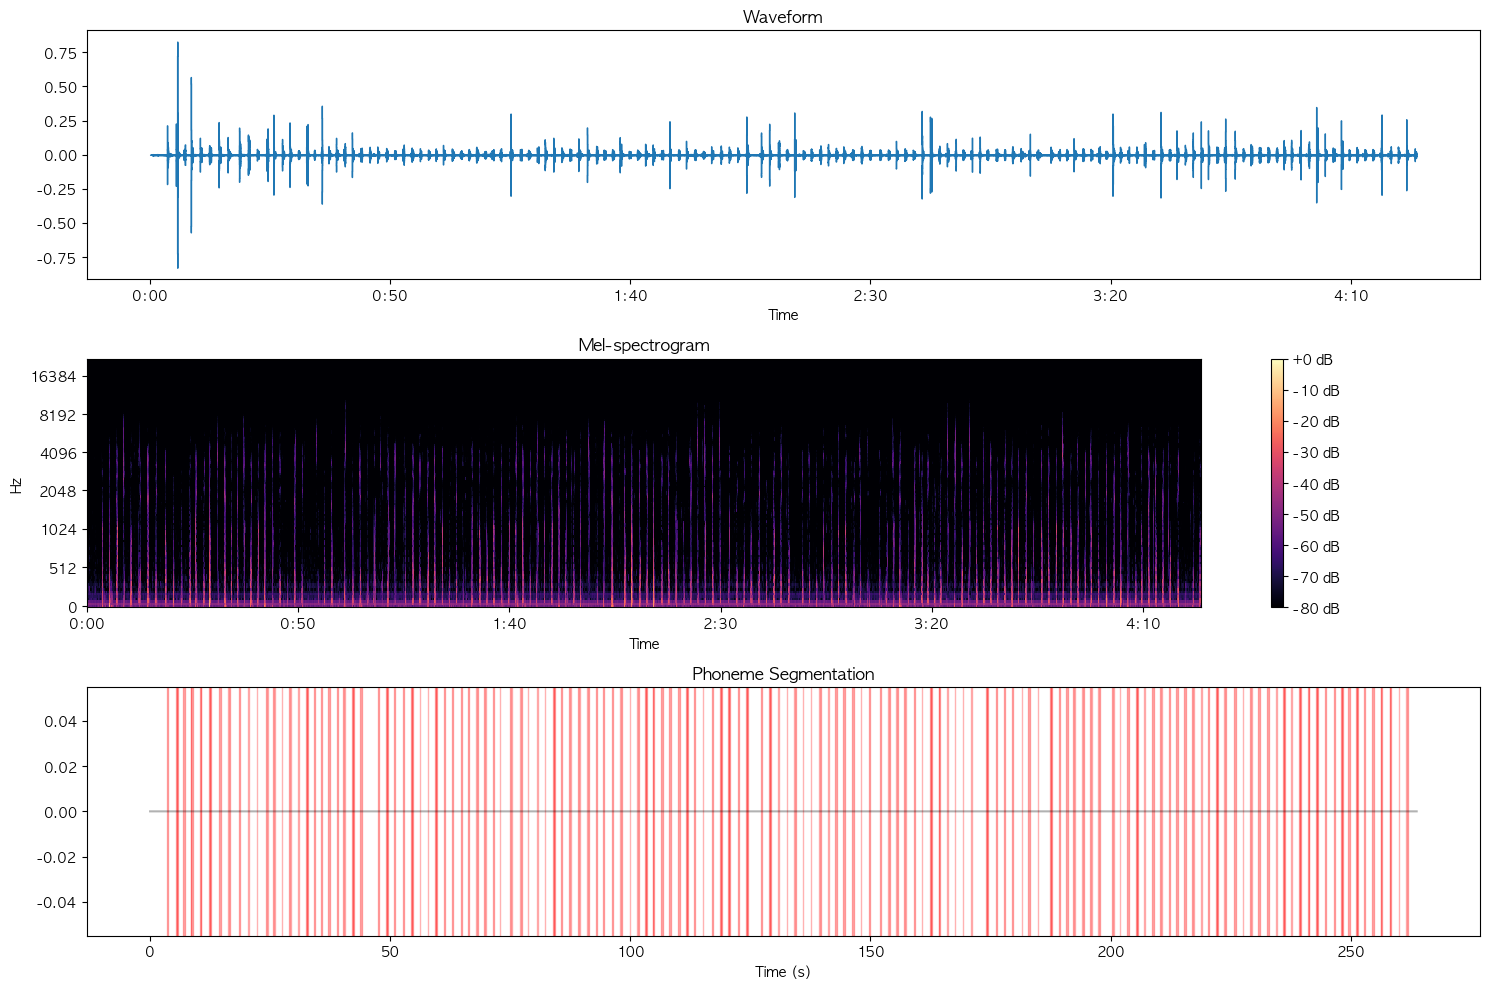


음소 구분 결과:
1. 3.49s - 3.77s: vowel
2. 5.35s - 5.51s: vowel
3. 5.63s - 5.74s: vowel
4. 6.93s - 7.34s: vowel
5. 8.48s - 8.54s: vowel
6. 8.61s - 8.88s: vowel
7. 10.34s - 10.50s: vowel
8. 10.55s - 10.66s: vowel
9. 12.25s - 12.41s: vowel
10. 12.52s - 12.70s: vowel
11. 14.26s - 14.66s: vowel
12. 16.13s - 16.24s: vowel
13. 16.45s - 16.64s: vowel
14. 18.48s - 18.80s: vowel
15. 20.34s - 20.43s: vowel
16. 20.62s - 20.69s: vowel
17. 22.22s - 22.31s: vowel
18. 24.18s - 24.25s: vowel
19. 24.45s - 24.56s: vowel
20. 25.67s - 25.77s: vowel
21. 25.94s - 26.06s: vowel
22. 27.45s - 27.56s: vowel
23. 29.01s - 29.15s: vowel
24. 29.26s - 29.34s: vowel
25. 30.78s - 30.87s: vowel
26. 30.93s - 31.02s: vowel
27. 32.51s - 32.68s: vowel
28. 32.76s - 32.88s: vowel
29. 34.09s - 34.26s: vowel
30. 35.60s - 35.84s: vowel
31. 37.08s - 37.45s: vowel
32. 38.94s - 39.08s: vowel
33. 40.24s - 40.31s: vowel
34. 40.48s - 40.66s: vowel
35. 42.02s - 42.18s: vowel
36. 42.26s - 42.40s: vowel
37. 43.76s - 44.12s: vowel
38. 47.53s 

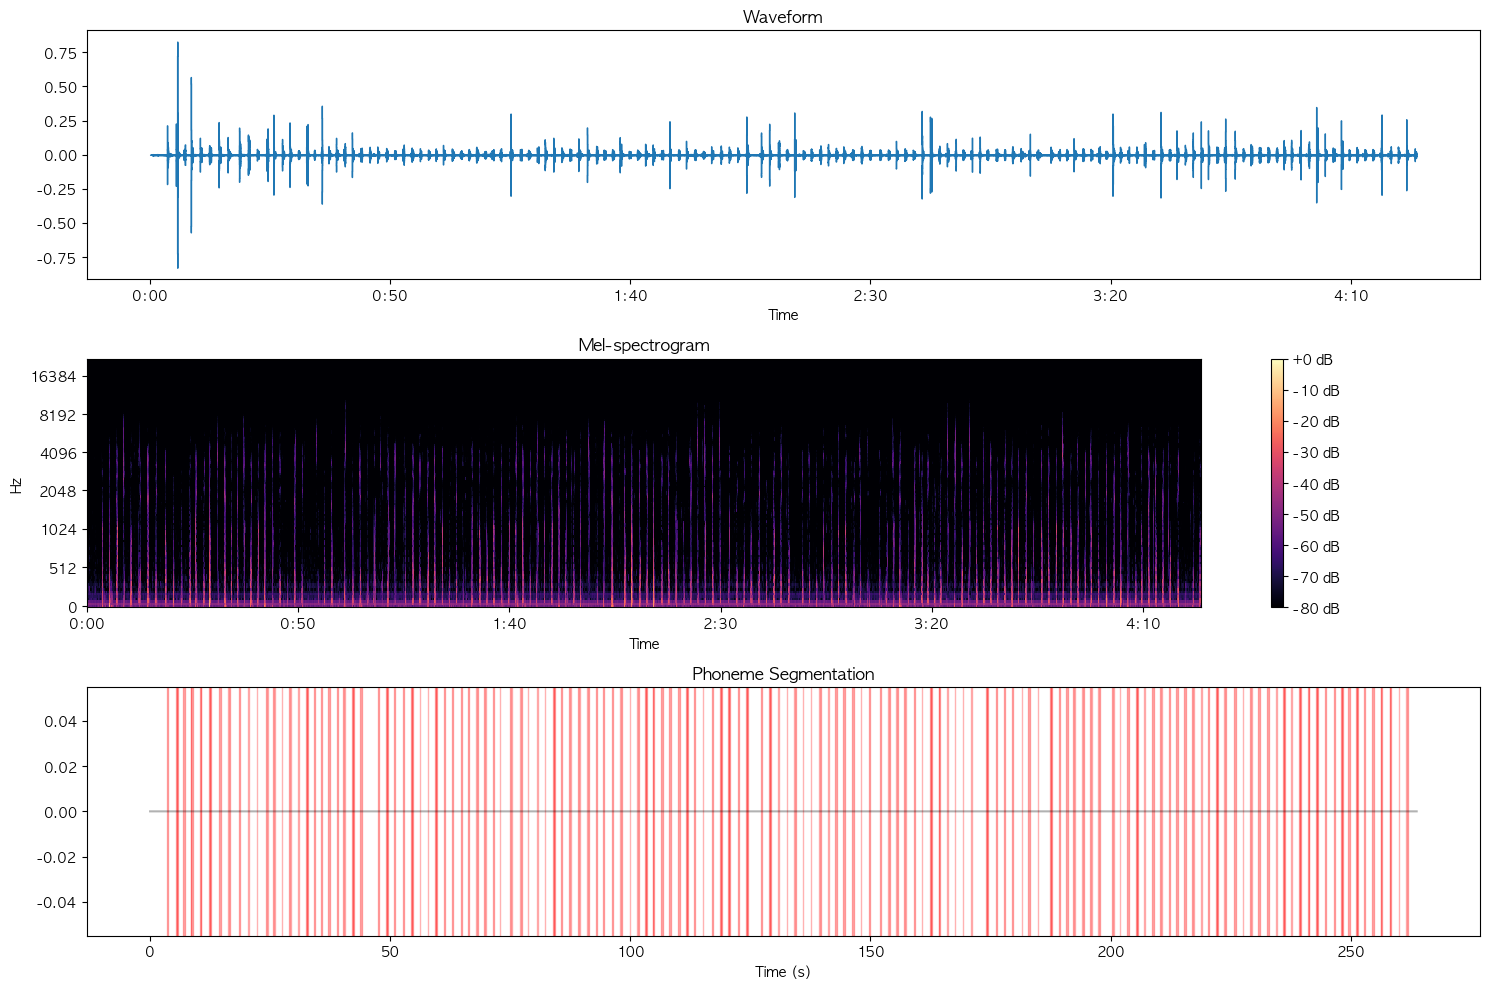


음소 구분 결과:
1. 3.49s - 3.77s: vowel
2. 5.35s - 5.51s: vowel
3. 5.63s - 5.74s: vowel
4. 6.93s - 7.34s: vowel
5. 8.48s - 8.54s: vowel
6. 8.61s - 8.88s: vowel
7. 10.34s - 10.50s: vowel
8. 10.55s - 10.66s: vowel
9. 12.25s - 12.41s: vowel
10. 12.52s - 12.70s: vowel
11. 14.26s - 14.66s: vowel
12. 16.13s - 16.24s: vowel
13. 16.45s - 16.64s: vowel
14. 18.48s - 18.80s: vowel
15. 20.34s - 20.43s: vowel
16. 20.62s - 20.69s: vowel
17. 22.22s - 22.31s: vowel
18. 24.18s - 24.25s: vowel
19. 24.45s - 24.56s: vowel
20. 25.67s - 25.77s: vowel
21. 25.94s - 26.06s: vowel
22. 27.45s - 27.56s: vowel
23. 29.01s - 29.15s: vowel
24. 29.26s - 29.34s: vowel
25. 30.78s - 30.87s: vowel
26. 30.93s - 31.02s: vowel
27. 32.51s - 32.68s: vowel
28. 32.76s - 32.88s: vowel
29. 34.09s - 34.26s: vowel
30. 35.60s - 35.84s: vowel
31. 37.08s - 37.45s: vowel
32. 38.94s - 39.08s: vowel
33. 40.24s - 40.31s: vowel
34. 40.48s - 40.66s: vowel
35. 42.02s - 42.18s: vowel
36. 42.26s - 42.40s: vowel
37. 43.76s - 44.12s: vowel
38. 47.53s 

In [17]:
import librosa
import librosa.display
import librosa.effects as effects
import numpy as np
import matplotlib.pyplot as plt
import parselmouth
from parselmouth import praat
import os
import sounddevice as sd

def load_audio(file_path):
    """
    오디오 파일을 로드합니다.
    
    Args:
        file_path (str): 오디오 파일 경로
    
    Returns:
        tuple: (y, sr) 오디오 데이터와 샘플링 레이트
    """
    y, sr = librosa.load(file_path, sr=None)
    return y, sr

def create_mel_spectrogram(y, sr, n_mels=128):
    """
    Mel-spectrogram을 생성합니다.
    
    Args:
        y (np.ndarray): 오디오 데이터
        sr (int): 샘플링 레이트
        n_mels (int): Mel 필터뱅크 개수
    
    Returns:
        tuple: (mel_spec, times) Mel-spectrogram과 시간축
    """
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    times = librosa.times_like(mel_spec, sr=sr)
    return mel_spec_db, times

def analyze_formants(y, sr):
    """
    포먼트를 분석합니다.
    
    Args:
        y (np.ndarray): 오디오 데이터
        sr (int): 샘플링 레이트
    
    Returns:
        tuple: (f1, f2) F1과 F2 포먼트 값
    """
    # numpy 배열을 Praat Sound 객체로 변환
    sound = parselmouth.Sound(y, sr)
    
    # 포먼트 추출
    formants = sound.to_formant_burg(time_step=0.01, 
                                    max_number_of_formants=5.0,
                                    maximum_formant=5000.0, 
                                    window_length=0.025, 
                                    pre_emphasis_from=50.0)
    
    # 시간에 따른 F1, F2 값 추출
    duration = sound.get_total_duration()
    times = np.arange(0, duration, 0.01)
    f1_values = []
    f2_values = []
    
    for t in times:
        try:
            f1 = formants.get_value_at_time(1, t)
            f2 = formants.get_value_at_time(2, t)
            if f1 and f2:
                f1_values.append(f1)
                f2_values.append(f2)
        except:
            pass
    
    return f1_values, f2_values, times

def detect_phonemes(mel_spec, times, f1_values, f2_values, energy_threshold=0.3, min_duration=0.05):
    """
    자음과 모음을 감지합니다.
    
    Args:
        mel_spec (np.ndarray): Mel-spectrogram
        times (np.ndarray): 시간축
        f1_values (list): F1 포먼트 값
        f2_values (list): F2 포먼트 값
        energy_threshold (float): 에너지 임계값
        min_duration (float): 최소 음소 지속 시간 (초)
    
    Returns:
        list: [(시작 시간, 종료 시간, 음소 타입), ...]
    """
    # 에너지 계산
    energy = np.mean(mel_spec, axis=0)
    energy = (energy - np.min(energy)) / (np.max(energy) - np.min(energy))
    
    # 에너지 임계값을 기준으로 음소 구분
    phonemes = []
    current_start = None
    current_type = None
    current_end = None
    
    for i in range(len(times)):
        if energy[i] > energy_threshold:
            if current_start is None:
                current_start = times[i]
                # F1, F2 값이 있는 경우 모음으로 판단
                if i < len(f1_values) and f1_values[i] > 0 and f2_values[i] > 0:
                    current_type = 'vowel'
                else:
                    current_type = 'consonant'
            current_end = times[i]
        elif current_start is not None:
            # 최소 지속 시간 확인
            if current_end - current_start >= min_duration:
                phonemes.append((current_start, current_end, current_type))
            current_start = None
            current_type = None
            current_end = None
    
    # 마지막 음소 처리
    if current_start is not None and current_end - current_start >= min_duration:
        phonemes.append((current_start, current_end, current_type))
    
    # 너무 짧은 구간 병합
    merged_phonemes = []
    if phonemes:
        current_start, current_end, current_type = phonemes[0]
        for start, end, phoneme_type in phonemes[1:]:
            if phoneme_type == current_type and start - current_end < min_duration:
                current_end = end
            else:
                merged_phonemes.append((current_start, current_end, current_type))
                current_start, current_end, current_type = start, end, phoneme_type
        merged_phonemes.append((current_start, current_end, current_type))
    
    return merged_phonemes

def visualize_results(y, sr, mel_spec, times, phonemes):
    """
    분석 결과를 시각화합니다.
    
    Args:
        y (np.ndarray): 오디오 데이터
        sr (int): 샘플링 레이트
        mel_spec (np.ndarray): Mel-spectrogram
        times (np.ndarray): 시간축
        phonemes (list): 음소 구분 결과
    """
    plt.figure(figsize=(15, 10))
    
    # 파형
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    
    # Mel-spectrogram
    plt.subplot(3, 1, 2)
    librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-spectrogram')
    
    # 음소 구분 결과
    plt.subplot(3, 1, 3)
    for start, end, phoneme_type in phonemes:
        color = 'red' if phoneme_type == 'vowel' else 'blue'
        plt.axvspan(start, end, alpha=0.3, color=color)
    plt.plot(times, np.zeros_like(times), 'k-', alpha=0.3)
    plt.title('Phoneme Segmentation')
    plt.xlabel('Time (s)')
    
    plt.tight_layout()
    plt.show()

def play_audio_segment(y, sr, start_time, end_time):
    """
    오디오의 특정 구간을 재생합니다.
    
    Args:
        y (np.ndarray): 오디오 데이터
        sr (int): 샘플링 레이트
        start_time (float): 시작 시간 (초)
        end_time (float): 종료 시간 (초)
    """
    # 시작과 종료 샘플 인덱스 계산
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    
    # 해당 구간 추출
    segment = y[start_sample:end_sample]
    
    # 재생
    print("재생 중...", end='', flush=True)
    sd.play(segment, sr)
    sd.wait()
    print(" 완료")
    return 0

def analyze_audio_file(file_path, phoneme_number=None):
    """
    오디오 파일을 분석하고 자음/모음을 구분합니다.
    
    Args:
        file_path (str): 오디오 파일 경로
        phoneme_number (int, optional): 재생할 음소 번호. None이면 모든 음소 정보만 반환
    """
    print(f"파일 분석 시작: {file_path}")
    
    # 오디오 로드
    y, sr = load_audio(file_path)
    print(f"오디오 로드 완료: 샘플링 레이트 {sr}Hz")
    
    # Mel-spectrogram 생성
    mel_spec, times = create_mel_spectrogram(y, sr)
    print(f"Mel-spectrogram 생성 완료: {len(times)} 프레임")
    
    # 포먼트 분석
    f1_values, f2_values, formant_times = analyze_formants(y, sr)
    print(f"포먼트 분석 완료: {len(f1_values)} 포인트")
    
    # 음소 구분
    phonemes = detect_phonemes(mel_spec, times, f1_values, f2_values)
    print(f"음소 구분 완료: {len(phonemes)} 개의 음소 발견")
    
    # 결과 시각화
    visualize_results(y, sr, mel_spec, times, phonemes)
    
    # 결과 출력
    print("\n음소 구분 결과:")
    for i, (start, end, phoneme_type) in enumerate(phonemes):
        print(f"{i+1}. {start:.2f}s - {end:.2f}s: {phoneme_type}")
    
    # 특정 음소 재생
    if phoneme_number is not None:
        try:
            idx = phoneme_number - 1
            if 0 <= idx < len(phonemes):
                start, end, phoneme_type = phonemes[idx]
                print(f"\n{phoneme_type} 재생 중...")
                play_audio_segment(y, sr, start, end)
            else:
                print(f"올바른 번호를 입력하세요. (1-{len(phonemes)})")
        except KeyboardInterrupt:
            print("\n재생이 중단되었습니다.")
    
    return phonemes, y, sr  # y와 sr도 함께 반환하도록 수정

def main():
    # 파일 경로 설정
    file_path = "../../../../Desktop/results/participant_038/038_stage4_20250416_1809.wav"
    
    if not os.path.exists(file_path):
        print("파일이 존재하지 않습니다.")
        return
    
    try:
        # 음소 분석만 수행
        phonemes, y, sr = analyze_audio_file(file_path)
        
        # 예시: 첫 번째 음소 재생
        if phonemes:
            analyze_audio_file(file_path, phoneme_number=1)
    except Exception as e:
        print(f"분석 중 오류 발생: {str(e)}")

if __name__ == "__main__":
    main() 

# For test sample

In [2514]:
audio_list

['22_stage1_20250404_1111.wav',
 '22_stage2_20250404_1112.wav',
 '22_stage3_20250404_1114.wav',
 '22_stage4_20250404_1114.wav',
 '22_stage5_20250404_1120.wav',
 '22_stage6_20250404_1125.wav']

In [2530]:
audio_path

'../../../../Desktop/results/participant_LY022(v)/22_stage4_20250404_1114.wav'

../../../../Desktop/results/participant_LY022(v)/22_stage4_20250404_1114.wav
(13, 133)


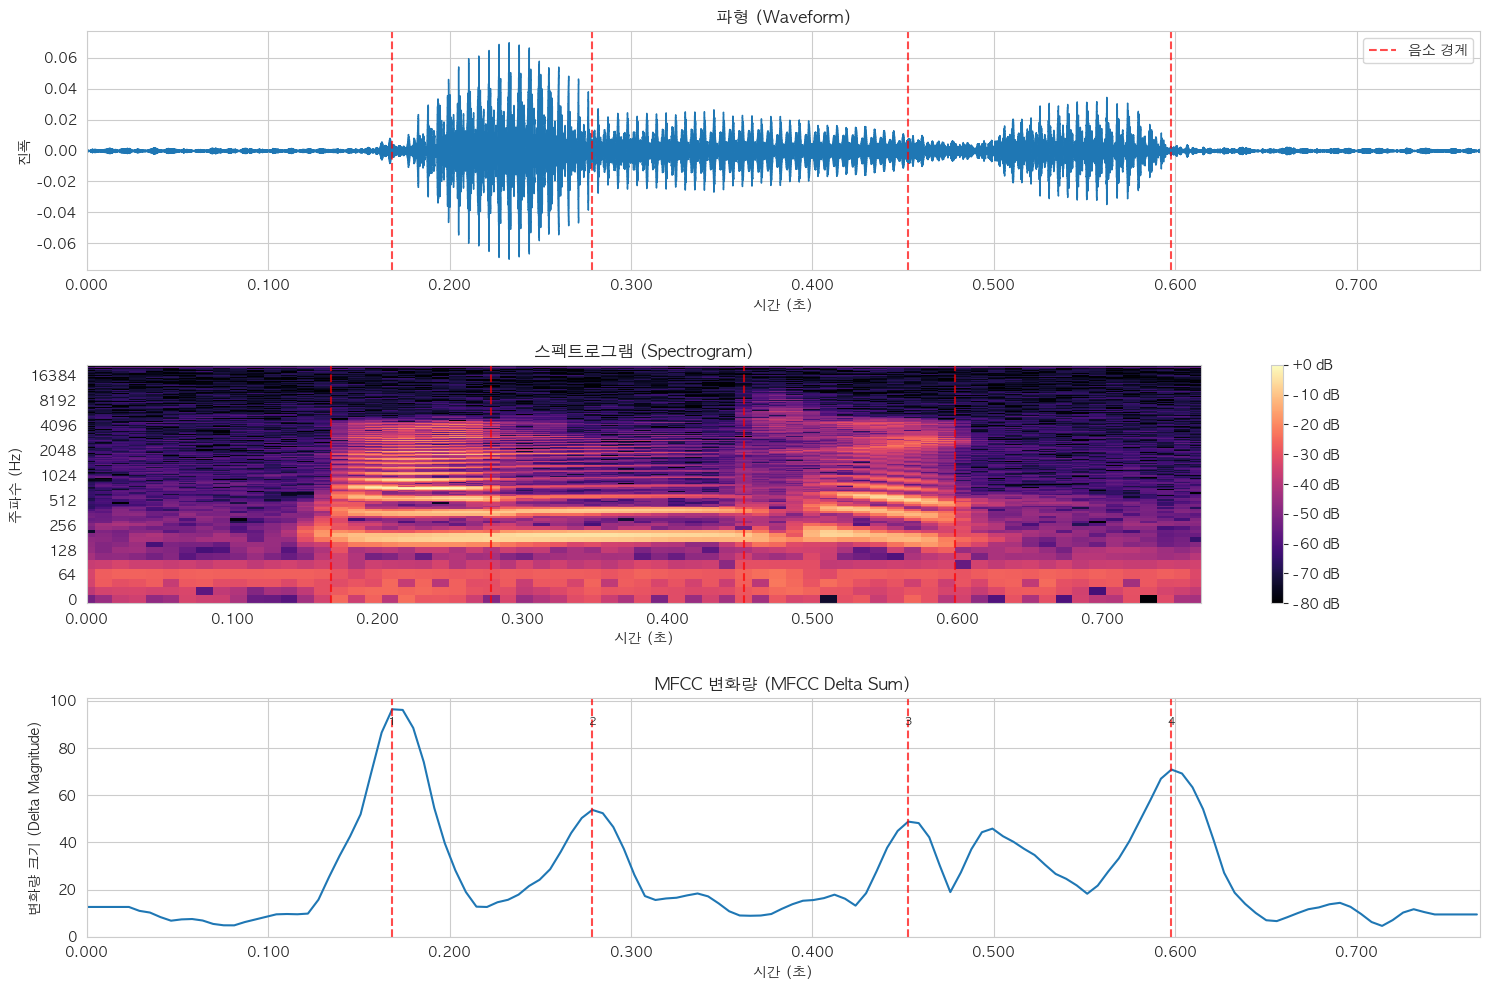

총 4개의 음소 경계 탐지
음소 경계 1: 0.168초
음소 경계 2: 0.279초
음소 경계 3: 0.453초
음소 경계 4: 0.598초


In [2531]:
print(audio_path)
segments = visualize_phoneme_segmentation(audio_path, start_time=start_time_list[16], end_time=end_time_list[16])

[0.04063492 0.16834467 0.30185941 0.5630839  0.69659864]
63.650999999999996
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage2_20250404_1112.wav
[0.04063492 0.16834467 0.30185941 0.5630839  0.69659864]
63.650999999999996
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage2_20250404_1112.wav
[0.04063492 0.16834467 0.30185941 0.5630839  0.69659864]
63.650999999999996
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage2_20250404_1112.wav
[0.04063492 0.16834467 0.30185941 0.5630839  0.69659864]
63.650999999999996
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage2_20250404_1112.wav
[0.04063492 0.16834467 0.30185941 0.5630839  0.69659864]
63.650999999999996


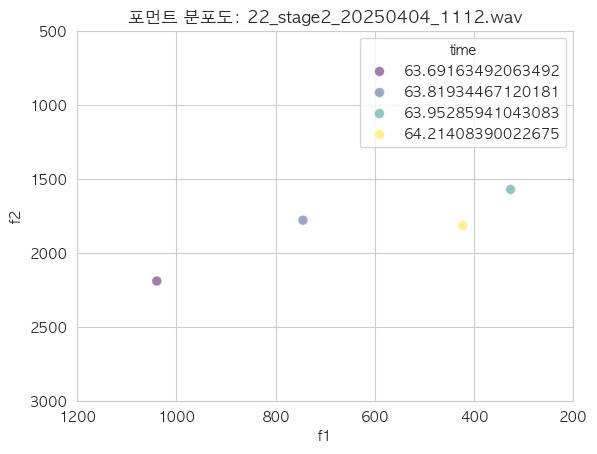

In [2506]:
# 통짜 파일이니 offset이 필요하겠네,,
stage = 1
data_exp = None
for idx in range(len(segments)):
    print(segments)
    print(start_time_list[34])
    if idx == len(segments)-1:
        continue
    if data_exp is None:
        data_exp = formant_analysis(participant_path, audio_list[stage], start_time=start_time_list[34]+ segments[idx], end_time=start_time_list[34]+segments[idx+1], time_step=-1)
    else:
        data_exp = pd.concat([data_exp, formant_analysis(participant_path, audio_list[stage], start_time=start_time_list[34]+ segments[idx], end_time=start_time_list[34]+segments[idx+1], time_step=-1)])
    

sns.scatterplot(data=data_exp, x="f1", y="f2", hue="time", palette="viridis", alpha=0.5, s=50)
ax = plt.gca()
ax.set_xlim(F1_MAX, F1_MIN)
ax.set_ylim(F2_MAX, F2_MIN)
plt.title(f"포먼트 분포도: {audio_list[stage]}")
plt.show()

[0.16834467 0.27863946 0.45278912 0.59791383]
35.699
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage4_20250404_1114.wav
[0.16834467 0.27863946 0.45278912 0.59791383]
35.699
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage4_20250404_1114.wav
[0.16834467 0.27863946 0.45278912 0.59791383]
35.699
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage4_20250404_1114.wav
[0.16834467 0.27863946 0.45278912 0.59791383]
35.699


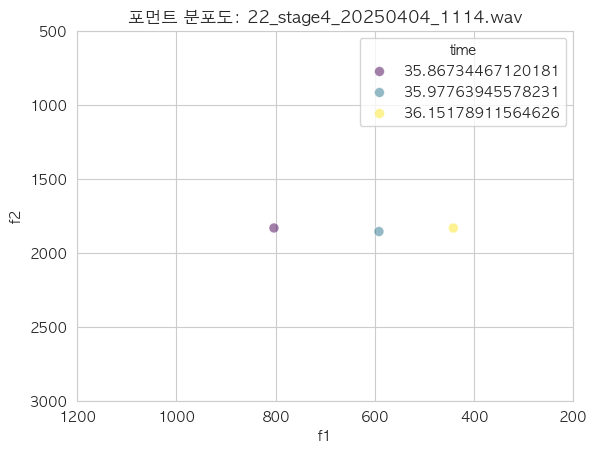

In [2533]:
# 통짜 파일이니 offset이 필요하겠네,,
stage = 3
data_exp = None
for idx in range(len(segments)):
    print(segments)
    print(start_time_list[16])
    if idx == len(segments)-1:
        continue
    if data_exp is None:
        data_exp = formant_analysis(participant_path, audio_list[stage], start_time=start_time_list[16]+ segments[idx], end_time=start_time_list[16]+segments[idx+1], time_step=-1)
    else:
        data_exp = pd.concat([data_exp, formant_analysis(participant_path, audio_list[stage], start_time=start_time_list[16]+ segments[idx], end_time=start_time_list[16]+segments[idx+1], time_step=-1)])
    

sns.scatterplot(data=data_exp, x="f1", y="f2", hue="time", palette="viridis", alpha=0.5, s=50)
ax = plt.gca()
ax.set_xlim(F1_MAX, F1_MIN)
ax.set_ylim(F2_MAX, F2_MIN)
plt.title(f"포먼트 분포도: {audio_list[stage]}")
plt.show()

[0.14512472 0.29605442 0.49922902 0.62113379]
58.034
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage6_20250404_1125.wav
[0.14512472 0.29605442 0.49922902 0.62113379]
58.034
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage6_20250404_1125.wav
[0.14512472 0.29605442 0.49922902 0.62113379]
58.034
filePath ../../../../Desktop/results/participant_LY022(v)
audio_name 22_stage6_20250404_1125.wav
[0.14512472 0.29605442 0.49922902 0.62113379]
58.034


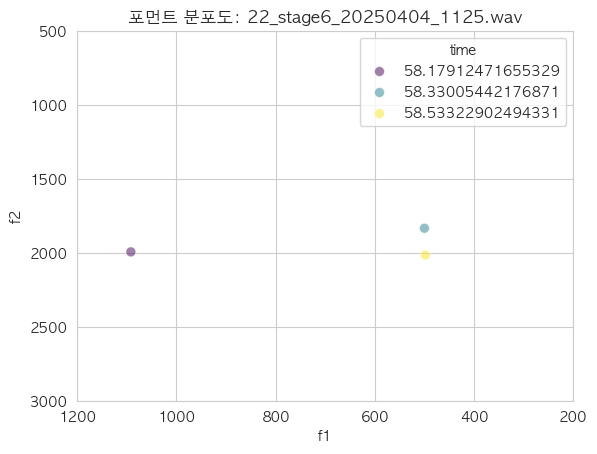

In [2513]:
# 통짜 파일이니 offset이 필요하겠네,,
stage = 5
data_exp = None
for idx in range(len(segments)):
    print(segments)
    print(start_time_list[34])
    if idx == len(segments)-1:
        continue
    if data_exp is None:
        data_exp = formant_analysis(participant_path, audio_list[stage], start_time=start_time_list[34]+ segments[idx], end_time=start_time_list[34]+segments[idx+1], time_step=-1)
    else:
        data_exp = pd.concat([data_exp, formant_analysis(participant_path, audio_list[stage], start_time=start_time_list[34]+ segments[idx], end_time=start_time_list[34]+segments[idx+1], time_step=-1)])
    

sns.scatterplot(data=data_exp, x="f1", y="f2", hue="time", palette="viridis", alpha=0.5, s=50)
ax = plt.gca()
ax.set_xlim(F1_MAX, F1_MIN)
ax.set_ylim(F2_MAX, F2_MIN)
plt.title(f"포먼트 분포도: {audio_list[stage]}")
plt.show()

# montreal-forced-Alignment

In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import openpyxl

## provision

In [51]:
provision_path = os.path.join("..", "audio-sample", "short-version-phonetic")
analysis_file = [analysis for analysis in os.listdir(provision_path) if analysis.endswith(".xlsx")][0]
sheet_name = pd.ExcelFile(os.path.join(provision_path, analysis_file)).sheet_names
#sheet_name -> Info, Stage
analysis_data = pd.read_excel(os.path.join(provision_path, analysis_file), sheet_name="Stage")
analysis_data.head()
    

,참가자번호,단계,단어,start_time,end_time,first_vowel,first_vowel_start,first_vowel_end,first_f1,first_f2,second_vowel,second_vowel_start,second_vowel_end,second_f1,second_f2
0,control,0,난색,0.03,0.52,ㅏ,0.08,0.15,635.681682,1367.457497,ㅐ,0.35,0.48,411.074506,1912.336967
1,control,0,난파,0.03,0.53,ㅏ,0.08,0.16,580.959463,1171.575050,ㅏ,0.38,0.53,675.106003,1439.215527
2,control,0,내빈,0.03,0.51,ㅐ,0.09,0.17,413.609050,1865.257928,ㅣ,0.25,0.34,304.325009,2218.989966
3,control,0,내사,0.03,0.53,ㅐ,0.10,0.20,448.732798,1804.281166,ㅏ,0.31,0.53,829.371915,2225.795780
4,control,0,녹각,0.03,0.49,ㅗ,0.06,0.22,461.622325,1779.562379,ㅏ,0.34,0.44,714.220236,2074.847600


In [77]:
vowel_data = pd.concat([analysis_data["first_vowel"], analysis_data["second_vowel"]])
f1_data = pd.concat([analysis_data["first_f1"], analysis_data["second_f1"]])
f2_data = pd.concat([analysis_data["first_f2"], analysis_data["second_f2"]])

control_data = pd.concat([vowel_data, f1_data, f2_data], axis=1, ignore_index=True)
control_data.columns = ["vowel", "f1", "f2"]
control_data.groupby("vowel").mean().to_csv(os.path.join(provision_path, "control_data_formant_mean.csv"))
control_data.groupby("vowel").mean()

,f1,f2
vowel,,
ㅏ,645.650330,1563.298030
ㅐ,423.830865,1877.891476
ㅗ,419.419739,1367.224249
ㅜ,421.765801,1586.097205
ㅣ,360.085355,2170.111040


In [80]:
control_f1 = control_data.groupby("vowel").mean()['f1']
control_f2 = control_data.groupby("vowel").mean()['f2']

## exp 

In [300]:
# 100번재 row NaN -> 수정,, 15번
# 마지막 단어 몰딩 후 모음이 NaN
#pd.read_csv("../../../../Desktop/results/participant_LY015/LY15_stage6_20250410_2058.csv")

,phoneme,f1,f2
0,u,409.727181,1876.638465
1,o,451.142472,1100.510178
2,i,311.516981,2027.025393
3,ɐ,712.509130,1446.587903
4,ɐ,818.236290,1281.315866
...,...,...,...
95,ɐ,728.101041,1173.792497
96,o,419.313510,2016.953392
97,ɛː,484.553755,2007.229377
98,o,422.840127,1500.141577


In [464]:
expPath = os.path.join(Path.home(), "Desktop", "results")
os.listdir(expPath)
participants = "participant_LY035"
participant_path = os.path.join(expPath, participants)
formant_csvs = [file for file in os.listdir(participant_path) if file.endswith(".csv")]
formant_csvs.sort()

In [465]:
def change_phonome_korean(phoneme):
    if "ɐ" in phoneme:
        return "ㅏ"
    elif "ɛ" in phoneme:
        return "ㅐ"
    elif "i" in phoneme:
        return "ㅣ"
    elif "o" in phoneme:
        return "ㅗ"
    elif "u" in phoneme:
        return "ㅜ"
    else:
        return phoneme

formant_mean_df = None
for formant_csv in formant_csvs:
    analysis_target = ["stage2", "stage4", "stage5", "stage6"]
    if any(target in formant_csv for target in analysis_target):
        print(formant_csv)
        print("="*20)
        formant_path = os.path.join(participant_path, formant_csv)
        formant_data = pd.read_csv(formant_path)
        formant_data["phoneme"] = formant_data["phoneme"].apply(change_phonome_korean)
        formant_group = formant_data.groupby("phoneme")
        if formant_mean_df is None:
            formant_mean_df = formant_group.mean()
        else:
            formant_mean_df = pd.concat([formant_mean_df, formant_group.mean()], axis=1)
formant_mean_df

        

35_stage2_20250411_1815.csv
35_stage4_20250411_1817.csv
35_stage5_20250411_1823.csv
35_stage6_20250411_1829.csv


,f1,f2,f1,f2,f1,f2,f1,f2
phoneme,,,,,,,,
ㅏ,707.322199,1404.163646,651.414260,1353.179294,646.047313,1379.040043,646.852673,1313.056718
ㅐ,461.923916,1921.529009,452.879385,1963.339935,450.870755,1900.606916,430.155283,1930.456484
ㅗ,505.015289,1465.887474,480.705764,1340.653604,508.028587,1427.651800,508.610680,1487.186463
ㅜ,509.518677,1695.641385,486.988992,1661.410958,513.601013,1667.545439,516.070755,1661.757944
ㅣ,319.375871,2064.870719,330.371052,2037.075802,378.378701,2020.744824,442.658959,2065.670048


In [466]:
formant_f1 = formant_mean_df.iloc[:, 0::2]
formant_f2 = formant_mean_df.iloc[:, 1::2]
formant_f1.columns = ["Stage1", "Stage2", "Stage3", "Stage4"]
formant_f2.columns = ["Stage1", "Stage2", "Stage3", "Stage4"]
formant_f1["std"]= formant_f1.std(axis=1)
formant_f2["std"]= formant_f2.std(axis=1)
formant_f1.head()
formant_f2.head()

,Stage1,Stage2,Stage3,Stage4,std
phoneme,,,,,
ㅏ,1404.163646,1353.179294,1379.040043,1313.056718,38.905302
ㅐ,1921.529009,1963.339935,1900.606916,1930.456484,26.098112
ㅗ,1465.887474,1340.653604,1427.651800,1487.186463,64.668434
ㅜ,1695.641385,1661.410958,1667.545439,1661.757944,16.279944
ㅣ,2064.870719,2037.075802,2020.744824,2065.670048,22.028198


In [467]:
control_f1

vowel
ㅏ    645.650330
ㅐ    423.830865
ㅗ    419.419739
ㅜ    421.765801
ㅣ    360.085355
Name: f1, dtype: float64

In [468]:
control_f2

vowel
ㅏ    1563.298030
ㅐ    1877.891476
ㅗ    1367.224249
ㅜ    1586.097205
ㅣ    2170.111040
Name: f2, dtype: float64

In [469]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # macOS

# 데이터 재구성 (long format으로 변환)
stages = ['Stage1', 'Stage2', 'Stage3', 'Stage4']
phonemes = ['ㅏ', 'ㅐ', 'ㅗ', 'ㅜ', 'ㅣ']

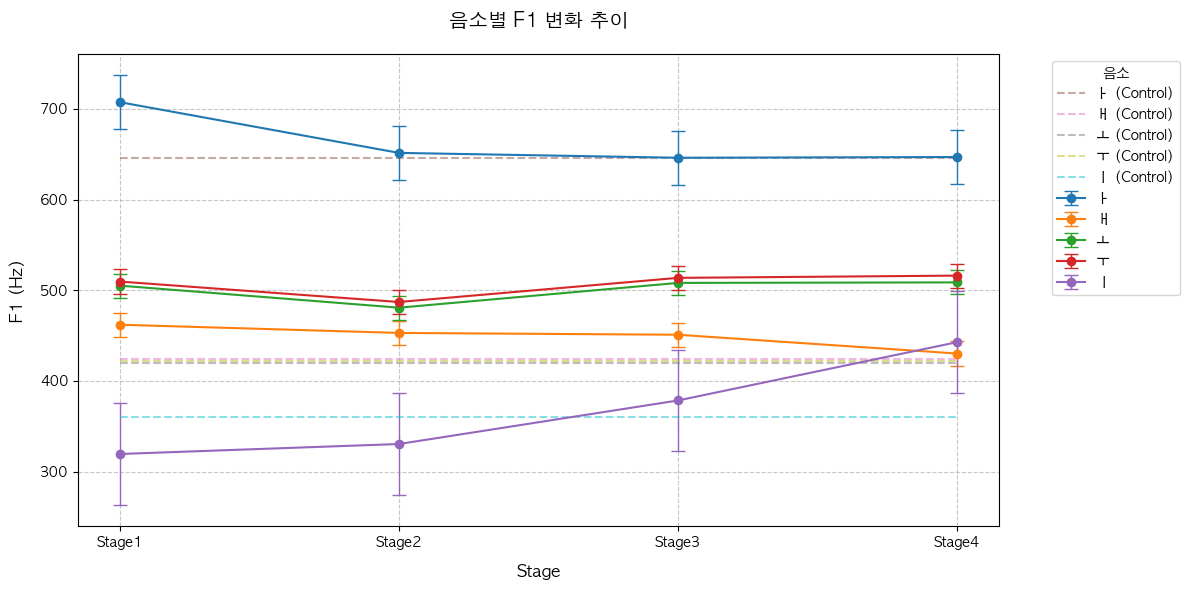

In [470]:
# 실험 데이터 재구성
plot_data = []
for phoneme in phonemes:
    for stage in stages:
        plot_data.append({
            'Phoneme': phoneme,
            'Stage': stage,
            'Value': formant_f1.loc[phoneme, stage],
            'Std': formant_f1.loc[phoneme, "std"],
            'Type': 'Experiment'
        })

# control 데이터 추가 : f1
control_data = {
    'ㅏ': 645.650330,
    'ㅐ': 423.830865,
    'ㅗ': 419.419739,
    'ㅜ': 421.765801,
    'ㅣ': 360.085355
}

for phoneme in phonemes:
    for stage in stages:
        plot_data.append({
            'Phoneme': phoneme,
            'Stage': stage,
            'Value': control_data[phoneme],
            'Std': 0,  # control 데이터는 표준편차 없음
            'Type': 'Control'
        })

# 데이터프레임 생성
plot_df = pd.DataFrame(plot_data)

# 그래프 스타일 설정
plt.figure(figsize=(12, 6))

# 실험 데이터 그리기 (error bar 포함)
for phoneme in phonemes:
    exp_data = plot_df[(plot_df['Type'] == 'Experiment') & (plot_df['Phoneme'] == phoneme)]
    plt.errorbar(x=range(len(stages)), 
                y=exp_data['Value'],
                yerr=exp_data['Std'],
                marker='o',
                label=phoneme,
                capsize=5,
                capthick=1,
                elinewidth=1)

# control 데이터 그리기
for phoneme in phonemes:
    ctrl_data = plot_df[(plot_df['Type'] == 'Control') & (plot_df['Phoneme'] == phoneme)]
    plt.plot(range(len(stages)), 
            ctrl_data['Value'],
            '--',
            alpha=0.5,
            label=f'{phoneme} (Control)')

# x축 레이블 설정
plt.xticks(range(len(stages)), stages)

# 그래프 스타일링
plt.title('음소별 F1 변화 추이', pad=20, fontsize=14)
plt.xlabel('Stage', labelpad=10, fontsize=12)
plt.ylabel('F1 (Hz)', labelpad=10, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 범례 위치 조정
plt.legend(title='음소', bbox_to_anchor=(1.05, 1), loc='upper left')

# 여백 조정
plt.tight_layout()

plt.show()

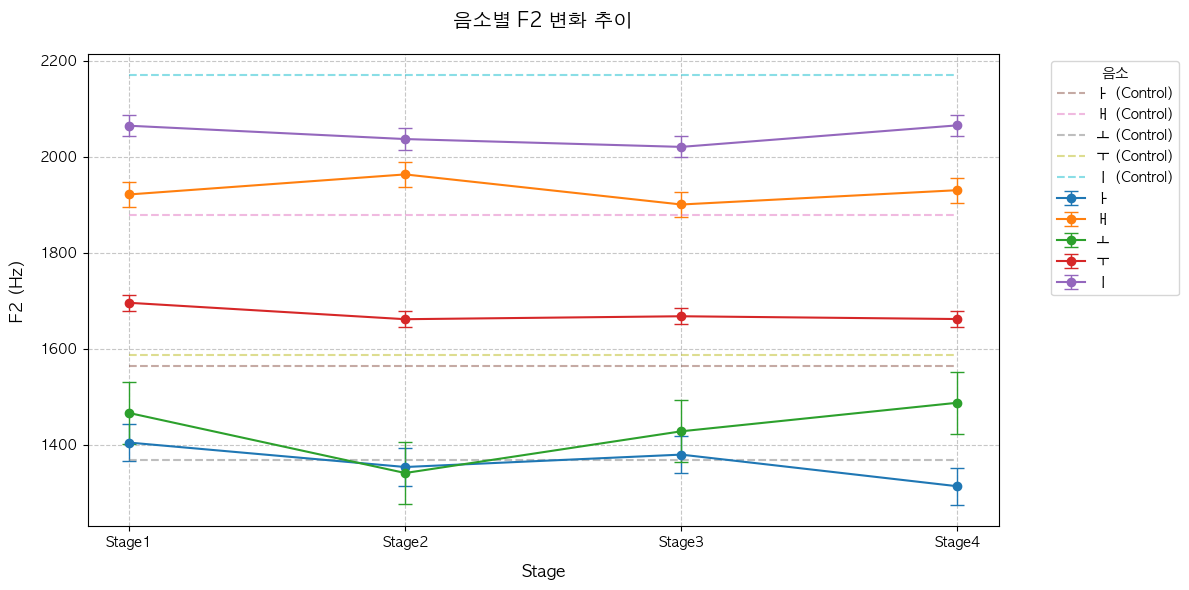

In [471]:
# 실험 데이터 재구성
plot_data = []
for phoneme in phonemes:
    for stage in stages:
        plot_data.append({
            'Phoneme': phoneme,
            'Stage': stage,
            'Value': formant_f2.loc[phoneme, stage],
            'Std': formant_f2.loc[phoneme, "std"],
            'Type': 'Experiment'
        })

# control 데이터 추가 : f2
control_data = {
    'ㅏ': 1563.298030,
    'ㅐ': 1877.891476,
    'ㅗ': 1367.224249,
    'ㅜ': 1586.097205,
    'ㅣ': 2170.111040
}

for phoneme in phonemes:
    for stage in stages:
        plot_data.append({
            'Phoneme': phoneme,
            'Stage': stage,
            'Value': control_data[phoneme],
            'Std': 0,  # control 데이터는 표준편차 없음
            'Type': 'Control'
        })

# 데이터프레임 생성
plot_df = pd.DataFrame(plot_data)

# 그래프 스타일 설정
plt.figure(figsize=(12, 6))

# 실험 데이터 그리기 (error bar 포함)
for phoneme in phonemes:
    exp_data = plot_df[(plot_df['Type'] == 'Experiment') & (plot_df['Phoneme'] == phoneme)]
    plt.errorbar(x=range(len(stages)), 
                y=exp_data['Value'],
                yerr=exp_data['Std'],
                marker='o',
                label=phoneme,
                capsize=5,
                capthick=1,
                elinewidth=1)

# control 데이터 그리기
for phoneme in phonemes:
    ctrl_data = plot_df[(plot_df['Type'] == 'Control') & (plot_df['Phoneme'] == phoneme)]
    plt.plot(range(len(stages)), 
            ctrl_data['Value'],
            '--',
            alpha=0.5,
            label=f'{phoneme} (Control)')

# x축 레이블 설정
plt.xticks(range(len(stages)), stages)

# 그래프 스타일링
plt.title('음소별 F2 변화 추이', pad=20, fontsize=14)
plt.xlabel('Stage', labelpad=10, fontsize=12)
plt.ylabel('F2 (Hz)', labelpad=10, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 범례 위치 조정
plt.legend(title='음소', bbox_to_anchor=(1.05, 1), loc='upper left')

# 여백 조정
plt.tight_layout()

plt.show()

<br/> f2만 보자면,, LY011 사전 연구와 동일하게 ㅐ 발음에서 수렴 발견(사람 조건, 여)
<br/>비슷한 맥락은 LY007에서는 ㅐ 발음에서 수렴이 덜 일어나는 듯(ai조건, 여).
<br/>LY002에서도 발산 확인(ai, 여)

<br/>19번이 진짜 잘 예상과 부합함. (남, ai) -> 일반적으로는 2,3 단계가 인간인 경우에는 3,4에서 발산이 발생해야 한다. 발음 자극을 제거했으니, <br/>그러나 이 친구 ai인걸 알자마자 반응 수렴 양상이 바뀜


## total trend

In [384]:
total = pd.read_excel("../../../../Desktop/results/survey.xlsx")[6:37]
total['list'] = total['list'].astype(int)
list1 = total[total["list"] == 1]
list2 = total[total["list"] == 2]
print(len(list1), len(list2))


16 15


In [402]:
list1['1. 참가자 번호'].to_list()

['LY019',
 'LY007',
 'LY002',
 'LY013',
 'LY025',
 'LY028',
 'LY023',
 'LY027',
 'LY015',
 'LY021',
 'LY031',
 'LY033',
 'LY032',
 'LY037',
 'LY038',
 'LY040']

In [ ]:
expPath = os.path.join(Path.home(), "Desktop", "results")
participants = os.listdir(expPath)
participants = [participant for participant in participants if (participant.startswith("participant") and "LY" in participant)]

list1_formants = [None, None, None, None, None, None]
list2_formants = [None, None, None, None, None, None]

for participant in participants:
    ## 예외 처리 -> 데이터 전처리 다시 필요,,
    if participant == "participant_LY015":
        print(participant)
        continue
    elif participant.replace("participant_", "") in list1['1. 참가자 번호'].to_list():
        print(participant)
        participant_path = os.path.join(expPath, participant)
        formant_csvs = [file for file in os.listdir(participant_path) if file.endswith(".csv")]
        formant_csvs.sort()
        
        for idx, formant_csv in enumerate(formant_csvs):    
            formant_data = pd.read_csv(os.path.join(participant_path, formant_csv))
            
            if list1_formants[idx] is None:
                list1_formants[idx] = formant_data
            else:
                list1_formants[idx] = pd.concat([list1_formants[idx], formant_data], axis=0)
    elif participant.replace("participant_", "") in list2['1. 참가자 번호'].to_list():
        participant_path = os.path.join(expPath, participant)
        formant_csvs = [file for file in os.listdir(participant_path) if file.endswith(".csv")]
        formant_csvs.sort()
        
        for idx, formant_csv in enumerate(formant_csvs):    
            formant_data = pd.read_csv(os.path.join(participant_path, formant_csv))
            
            if list2_formants[idx] is None:
                list2_formants[idx] = formant_data
            else:
                list2_formants[idx] = pd.concat([list2_formants[idx], formant_data], axis=0)
    else:
        continue

participant_LY028
participant_LY019
participant_LY021
participant_LY027
participant_LY033
participant_LY002
participant_LY032
participant_LY013
participant_LY025
participant_LY040
participant_LY023
participant_LY015
participant_LY037
participant_LY038
participant_LY007
participant_LY031


In [414]:
# remove practice stage
del list1_formants[0]
del list1_formants[1]
del list2_formants[0]
del list2_formants[1]

In [ ]:
# change phoneme to korean
for df in list1_formants:
    df['phoneme'] = df['phoneme'].apply(change_phonome_korean)

for df in list2_formants:
    df['phoneme'] = df['phoneme'].apply(change_phonome_korean)

In [429]:
list1_formants[0][['phoneme','f1']]

,phoneme,f1
0,ㅏ,650.149066
1,ㅜ,552.274930
2,ㅗ,420.475761
3,ㅏ,784.859916
4,ㅐ,927.613514
...,...,...
95,ㅐ,517.184953
96,ㅣ,269.492240
97,ㅣ,378.480324
98,ㅣ,393.785628


In [430]:
list1_formants_f1 = None
list1_formant_f2 = None
list2_formant_f1 = None
list2_formant_f2 = None

for list1_formant in list1_formants:
    if list1_formants_f1 is None:
        list1_formants_f1 = list1_formant[['phoneme','f1']]
        list1_formant_f2 = list1_formant[['phoneme','f2']]
    else:
        list1_formants_f1 = pd.concat([list1_formants_f1, list1_formant[['phoneme','f1']]], axis=0)
        list1_formant_f2 = pd.concat([list1_formant_f2, list1_formant[['phoneme','f2']]], axis=0)


for list2_formant in list2_formants:
    if list2_formant_f2 is None:
        list2_formant_f2 = list2_formant[['phoneme','f2']]
        list2_formant_f1 = list2_formant[['phoneme','f1']]
    else:
        list2_formant_f2 = pd.concat([list2_formant_f2, list2_formant[['phoneme','f2']]], axis=0)
        list2_formant_f1 = pd.concat([list2_formant_f1, list2_formant[['phoneme','f1']]], axis=0)

In [431]:
list1_formants_f1

,phoneme,f1
0,ㅏ,650.149066
1,ㅜ,552.274930
2,ㅗ,420.475761
3,ㅏ,784.859916
4,ㅐ,927.613514
...,...,...
95,ㅗ,626.841220
96,ㅐ,465.119298
97,ㅗ,512.936095
98,ㅣ,288.522101


In [415]:
# 실험 데이터 재구성
plot_data = []
for phoneme in phonemes:
    for stage in stages:
        plot_data.append({
            'Phoneme': phoneme,
            'Stage': stage,
            'Value': formant_f1.loc[phoneme, stage],
            'Std': formant_f1.loc[phoneme, "std"],
            'Type': 'Experiment'
        })

# control 데이터 추가 : f1
control_data = {
    'ㅏ': 645.650330,
    'ㅐ': 423.830865,
    'ㅗ': 419.419739,
    'ㅜ': 421.765801,
    'ㅣ': 360.085355
}

for phoneme in phonemes:
    for stage in stages:
        plot_data.append({
            'Phoneme': phoneme,
            'Stage': stage,
            'Value': control_data[phoneme],
            'Std': 0,  # control 데이터는 표준편차 없음
            'Type': 'Control'
        })

# 데이터프레임 생성
plot_df = pd.DataFrame(plot_data)

# 그래프 스타일 설정
plt.figure(figsize=(12, 6))

# 실험 데이터 그리기 (error bar 포함)
for phoneme in phonemes:
    exp_data = plot_df[(plot_df['Type'] == 'Experiment') & (plot_df['Phoneme'] == phoneme)]
    plt.errorbar(x=range(len(stages)), 
                y=exp_data['Value'],
                yerr=exp_data['Std'],
                marker='o',
                label=phoneme,
                capsize=5,
                capthick=1,
                elinewidth=1)

# control 데이터 그리기
for phoneme in phonemes:
    ctrl_data = plot_df[(plot_df['Type'] == 'Control') & (plot_df['Phoneme'] == phoneme)]
    plt.plot(range(len(stages)), 
            ctrl_data['Value'],
            '--',
            alpha=0.5,
            label=f'{phoneme} (Control)')

# x축 레이블 설정
plt.xticks(range(len(stages)), stages)

# 그래프 스타일링
plt.title('음소별 F1 변화 추이', pad=20, fontsize=14)
plt.xlabel('Stage', labelpad=10, fontsize=12)
plt.ylabel('F1 (Hz)', labelpad=10, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 범례 위치 조정
plt.legend(title='음소', bbox_to_anchor=(1.05, 1), loc='upper left')

# 여백 조정
plt.tight_layout()

plt.show()

,phoneme,f1,f2
0,ɐ,650.149066,1170.342619
1,u,552.274930,1386.620035
2,o,420.475761,1019.977010
3,ɐ,784.859916,1328.471328
4,ɛː,927.613514,2308.278660
...,...,...,...
95,ɛː,517.184953,1768.138815
96,i,269.492240,1894.315924
97,i,378.480324,1999.277993
98,i,393.785628,2017.362637
